# Implementing VAR in PyMC3

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
import pymc3 as pm
import theano.tensor as tt

In [3]:
import matplotlib.pyplot as plt
import arviz as az

In [4]:
import pymc3.distributions.transforms as tr

# Generate VAR

In [5]:
from regime_switching.generate import chain, ar

In [6]:
T = 100
n_endog = 1
n_lag_endog = 1

# n_exog = 0

In [7]:
vg = ar.VARXGenerator.get_random_instance(endog=n_endog, lag_endog=n_lag_endog)
vg

VARXGenerator with params:
  <xarray.Dataset>
  Dimensions:          (endog: 1, exog: 0, lag_endog: 1, lag_exog: 0, target: 1)
  Coordinates:
    * lag_exog         (lag_exog) int64 
    * lag_endog        (lag_endog) int64 1
    * endog            (endog) int64 0
    * target           (target) int64 0
    * exog             (exog) int64 
  Data variables:
      coef_ar          (target, endog, lag_endog) float64 0.6033
      coef_exog        (target, exog, lag_exog) float64 
      coef_covariance  (target, endog) float64 0.7048
      coef_const       (target) float64 0.7513

In [8]:
raw_data = vg.generate(T + n_lag_endog)
raw_data

<xarray.Dataset>
Dimensions:  (target: 1, time: 101)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99 100
  * target   (target) int64 0
Data variables:
    output   (time, target) float64 -0.5552 1.126 2.197 ... 0.2918 1.06 1.133

In [9]:
init_vals = raw_data.where(raw_data['time'] < n_lag_endog, drop=True)
data = raw_data.where(raw_data['time'] >= n_lag_endog, drop=True)
data

<xarray.Dataset>
Dimensions:  (target: 1, time: 100)
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 ... 92 93 94 95 96 97 98 99 100
  * target   (target) int64 0
Data variables:
    output   (time, target) float64 1.126 2.197 0.8261 ... 0.2918 1.06 1.133

# Internals of `logp`

## Coefficient shapes

In [10]:
# Using ACTUAL parameter values here, but shapes will be same for pymc3 params

t_const = tt.as_tensor(vg.coef_const.values)
t_ar = tt.as_tensor(vg.coef_ar.values)
t_cov = tt.as_tensor(vg.coef_covariance.values)

# NOTE: Initial values not currently set in VARXGenerator
t_init = tt.as_tensor(np.full(shape=(n_lag_endog, n_endog), fill_value=0))

print(
    "const:", t_const.shape.eval(), "==", (n_endog,),
    "\nar:", t_ar.shape.eval(), "==", (n_endog, n_endog, n_lag_endog),
    "\ncov:", t_cov.shape.eval(), "==", (n_endog, n_endog),
    "\ninit:", t_init.shape.eval(), "==", (n_lag_endog, n_endog),
)

const: [1] == (1,) 
ar: [1 1 1] == (1, 1, 1) 
cov: [1 1] == (1, 1) 
init: [1 1] == (1, 1)


## Pad the data

In [11]:
t_data = tt.as_tensor(data['output'].values)
t_data_pre = tt.concatenate([t_init, t_data], axis=0)
print(
    "data:", t_data.shape.eval(), "==", (T, n_endog),
    "\npadded:", t_data_pre.shape.eval(), "==", (n_lag_endog + T, n_endog)
)

data: [100   1] == (100, 1) 
padded: [101   1] == (101, 1)


## Get expected mean

In [12]:
# Sum up total AR effect
effect_ar = []
for i in range(n_lag_endog):
    # lag is i+1
    _start = n_lag_endog - (i + 1)
    _end = -(i + 1)
    q = tt.dot(t_data_pre[_start:_end, :], t_ar[:, :, i])
    effect_ar.append(q)
effect_ar = tt.add(*effect_ar)
effect_ar.shape.eval()  # == (T, n_endog)

array([100,   1])

In [13]:
expected_mean = effect_ar + t_const[None, :]
errors = t_data - expected_mean
errors.shape.eval()  # == (T, n_endog)

array([100,   1])

## Find likelihood

In [14]:
dist_innov = pm.MvNormal.dist(mu=0, **{"cov": t_cov})

like_innov = dist_innov.logp(errors)
like_innov.shape.eval()  # == (T, )

array([100])

In [15]:
dist_init = pm.Flat.dist()
# dist_init = pm.Normal.dist(mu=0, sigma=10, shape=[2])

like_init = dist_init.logp(t_init)  # == (n_lag_endog, n_endog)?
like_init.shape.eval()  # == (n_lag_endog, n_endog) ?

array([1, 1])

In [16]:
like_total = tt.sum(like_init) + tt.sum(like_innov)
like_total.shape.eval()  # == tuple()

array([], dtype=int64)

# Create class

In [17]:
# pm.distributions.continuous.get_tau_sigma

In [18]:
# Using ACTUAL parameter values here, but shapes will be same for pymc3 params

t_const = tt.as_tensor(vg.coef_const.values)
t_ar = tt.as_tensor(vg.coef_ar.values)
t_cov = tt.as_tensor(vg.coef_covariance.values)

# NOTE: Initial values not currently set in VARXGenerator
t_init = tt.as_tensor(np.full(shape=(n_lag_endog, n_endog), fill_value=0))

print(
    "const:", t_const.shape.eval(), "==", (n_endog,),
    "\nar:", t_ar.shape.eval(), "==", (n_endog, n_endog, n_lag_endog),
    "\ncov:", t_cov.shape.eval(), "==", (n_endog, n_endog),
    "\ninit:", t_init.shape.eval(), "==", (n_lag_endog, n_endog),
)

const: [1] == (1,) 
ar: [1 1 1] == (1, 1, 1) 
cov: [1 1] == (1, 1) 
init: [1 1] == (1, 1)


In [19]:
class VAR(pm.Continuous):
    
    def __init__(
        self, 
        n_endog, n_lag_endog, 
        t_const, t_init, t_ar,
        cov=None, tau=None, chol=None, lower=True,
        dist_init=pm.Flat.dist(), 
        *args, **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.n_endog = int(n_endog)
        self.n_lag_endog = int(n_lag_endog)

        self.t_const = tt.as_tensor_variable(t_const)
        self.t_init = tt.as_tensor_variable(t_init)
        self.t_ar = tt.as_tensor_variable(t_ar)
        
        # Covariance distribution args for innovation process
        # TODO: Maybe allow non-MvNormal innovation dist?
        self.cov_args = dict(cov=cov, tau=tau, chol=chol, lower=lower)
        
        # Distribution for initial values - default is Flat a.k.a. "no idea" 
        self.dist_init = dist_init
        
        # Test value
        self.mean = tt.as_tensor_variable(np.zeros(shape=(n_endog,)))
        
    @property
    def dist_innov(self) -> pm.Distribution:
        return pm.MvNormal.dist(mu=0, **self.cov_args)
        
    def logp(self, value: tt.Tensor) -> tt.TensorVariable:
        """f"""
        
        # Prepend initial values
        t_data = tt.as_tensor(value)
        try:
            t_data_pre = tt.concatenate([self.t_init, t_data], axis=0)
        except Exception:
            t_data_pre = self.t_init
        
        # Sum up total AR effect
        effect_ar = []
        for i in range(n_lag_endog):
            # lag is i+1
            _start = n_lag_endog - (i + 1)
            _end = -(i + 1)
            q = tt.dot(t_data_pre[_start:_end, :], self.t_ar[:, :, i])
            effect_ar.append(q)
        effect_ar = tt.add(*effect_ar)
        # effect_ar.shape.eval()  # == (T, n_endog)
        
        # Add constant to get errors
        expected_mean = effect_ar + self.t_const[None, :]
        errors = t_data - expected_mean
        # errors.shape.eval()  # == (T, n_endog)
        
        # Get likelihoods
        dist_innov = pm.MvNormal.dist(mu=0, **self.cov_args)
        like_innov = dist_innov.logp(errors)
        # like_innov.shape.eval()  # == (T, )
        
        dist_init = self.dist_init
        like_init = dist_init.logp(t_init)  # == (n_lag_endog, n_endog)?
        # like_init.shape.eval()  # == (n_lag_endog, n_endog) ?
        
        like_total = tt.sum(like_init) + tt.sum(like_innov)
        # like_total.shape.eval()  # == tuple()
        
        return like_total
    
    def random(self, point=None, size=None):
        print(point)
        print(size)
        random_samples = np.zeros(shape=size)
        
        return random_samples

In [36]:
self = var.distribution
array = np.array
point = {
    'chol_cov_cholesky-cov-packed__': array([0.06649683]), 
    't_const': array([1.00700788]), 
    't_init': array([[1.76446253]]), 
    't_ar_interval__': array([[[1.2601324]]]), 
    'chol_cov': array([1.06875757]), 
    't_cov': array([[1.14224275]]), 
    't_ar': array([[[0.5580978]]]),
}
size = None

In [37]:
self.t_const

t_const

In [39]:
self.dist_innov = pm.MvNormal.dist(mu=0, **self.cov_args)

In [40]:
a_const = point[self.t_const.name]
a_init = point[self.t_init.name]
a_ar = point[self.t_ar.name]

# a_cov = point[self.t_cov.name]  # hmm


In [55]:
b_key = [k for k in ['cov', 'tau', 'chol'] if self.cov_args[k] is not None][0]
b_val = self.cov_args[b_key]
b_key, b_val

('chol', AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True}.0)

In [41]:
a_const

array([1.00700788])

In [20]:
# VAR.dist(n_endog=n_endog, n_lag_endog=n_lag_endog).logp(data['output'].values)

## Test in model

### Build model

In [21]:
import warnings

warnings.simplefilter('ignore', FutureWarning)

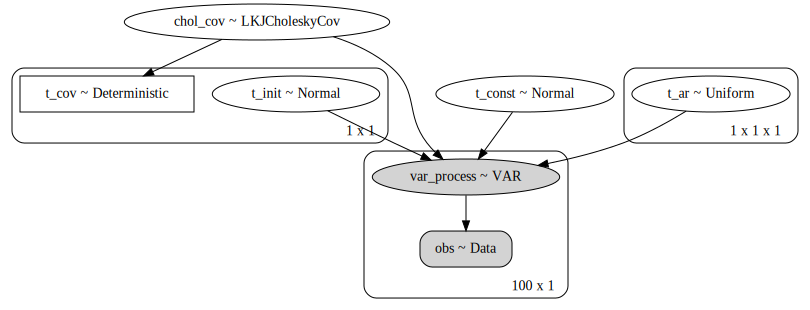

In [22]:
with pm.Model() as m:
    sd_dist = pm.HalfCauchy.dist(beta=2.5)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=n_endog, sd_dist=sd_dist)
    chol = pm.expand_packed_triangular(n_endog, packed_chol, lower=True)
    
    cov = pm.Deterministic('t_cov', tt.dot(chol, chol.T))
    
    pm.Normal('t_const', 0, 10, shape=(n_endog,))
    pm.Normal('t_init', 0, 10, shape=(n_lag_endog, n_endog))

    # Note: maybe try Beta? Truncated Cauchy/Normal?
    pm.Uniform('t_ar', -1, 1, shape=(n_endog, n_endog, n_lag_endog))
    
    obs = pm.Data('obs', data['output'].values)
    var = VAR(
        'var_process', 
        n_endog=n_endog, n_lag_endog=n_lag_endog, 
        t_const=m['t_const'], 
        t_init=m['t_init'],
        t_ar=m['t_ar'],
        chol=chol, 
        observed=m['obs'],
    )
    
pm.model_to_graphviz(m)

### Fit

In [23]:
with m:
    trace = pm.sample(draws=1000, tune=2000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [t_ar, t_init, t_const, chol_cov]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [01:18<00:00, 76.41draws/s] 


### Get posterior predictive

In [24]:
with m:
    ppc = pm.sample_posterior_predictive(trace)

  1%|          | 11/2000 [00:00<00:41, 47.46it/s]

{'chol_cov_cholesky-cov-packed__': array([0.06649683]), 't_const': array([1.00700788]), 't_init': array([[1.76446253]]), 't_ar_interval__': array([[[1.2601324]]]), 'chol_cov': array([1.06875757]), 't_cov': array([[1.14224275]]), 't_ar': array([[[0.5580978]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.01316993]), 't_const': array([0.79132719]), 't_init': array([[1.97404668]]), 't_ar_interval__': array([[[1.22538538]]]), 'chol_cov': array([0.98691641]), 't_cov': array([[0.974004]]), 't_ar': array([[[0.54601977]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.08273289]), 't_const': array([0.52443987]), 't_init': array([[-0.68396788]]), 't_ar_interval__': array([[[1.95565935]]]), 'chol_cov': array([0.92059701]), 't_cov': array([[0.84749886]]), 't_ar': array([[[0.75212485]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.02056422]), 't_const': array([0.76620577]), 't_init': array([[0.19402273]]), 't_ar_interval__': array([[[1.33453746]]]), 'chol_cov': array([1.02077713]),

  1%|          | 24/2000 [00:00<00:37, 52.63it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.11636046]), 't_const': array([0.65196355]), 't_init': array([[2.98536637]]), 't_ar_interval__': array([[[1.35336647]]]), 'chol_cov': array([0.8901543]), 't_cov': array([[0.79237468]]), 't_ar': array([[[0.58935892]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02369302]), 't_const': array([0.8949814]), 't_init': array([[0.33942834]]), 't_ar_interval__': array([[[1.43887632]]]), 'chol_cov': array([0.97658545]), 't_cov': array([[0.95371915]]), 't_ar': array([[[0.61656117]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.01284022]), 't_const': array([0.53564871]), 't_init': array([[-1.01845524]]), 't_ar_interval__': array([[[1.84994649]]]), 'chol_cov': array([0.98724186]), 't_cov': array([[0.97464649]]), 't_ar': array([[[0.72824164]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.02218264]), 't_const': array([0.78654863]), 't_init': array([[2.16614006]]), 't_ar_interval__': array([[[1.35602208]]]), 'chol_cov': array([1.02243051

  2%|▏         | 38/2000 [00:00<00:34, 57.70it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.09017615]), 't_const': array([0.76828123]), 't_init': array([[1.04955655]]), 't_ar_interval__': array([[[1.55634918]]]), 'chol_cov': array([0.91377021]), 't_cov': array([[0.83497599]]), 't_ar': array([[[0.65165772]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.092538]), 't_const': array([0.77211859]), 't_init': array([[0.84483691]]), 't_ar_interval__': array([[[1.32941004]]]), 'chol_cov': array([0.91161457]), 't_cov': array([[0.83104112]]), 't_ar': array([[[0.58148606]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.09242137]), 't_const': array([0.53963946]), 't_init': array([[1.79550751]]), 't_ar_interval__': array([[[1.50107388]]]), 'chol_cov': array([0.9117209]), 't_cov': array([[0.83123499]]), 't_ar': array([[[0.63546917]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.09242137]), 't_const': array([0.53963946]), 't_init': array([[1.79550751]]), 't_ar_interval__': array([[[1.50107388]]]), 'chol_cov': array([0.9117209])

  2%|▎         | 50/2000 [00:00<00:33, 57.70it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.0450691]), 't_const': array([0.86672707]), 't_init': array([[1.19463308]]), 't_ar_interval__': array([[[1.41735497]]]), 'chol_cov': array([0.95593143]), 't_cov': array([[0.91380489]]), 't_ar': array([[[0.60984685]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03246244]), 't_const': array([0.69438692]), 't_init': array([[0.5371687]]), 't_ar_interval__': array([[[1.43032205]]]), 'chol_cov': array([0.96805881]), 't_cov': array([[0.93713786]]), 't_ar': array([[[0.61390298]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.00723982]), 't_const': array([0.66889747]), 't_init': array([[0.97697453]]), 't_ar_interval__': array([[[1.83805572]]]), 'chol_cov': array([1.00726609]), 't_cov': array([[1.01458497]]), 't_ar': array([[[0.7254372]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02543085]), 't_const': array([0.67665269]), 't_init': array([[1.13764627]]), 't_ar_interval__': array([[[1.59881301]]]), 'chol_cov': array([0.97488979])

  3%|▎         | 56/2000 [00:00<00:35, 54.99it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.06458448]), 't_const': array([0.5708376]), 't_init': array([[-0.55840752]]), 't_ar_interval__': array([[[1.64250252]]]), 'chol_cov': array([0.93745691]), 't_cov': array([[0.87882547]]), 't_ar': array([[[0.67575034]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0276749]), 't_const': array([1.01073112]), 't_init': array([[0.76389682]]), 't_ar_interval__': array([[[1.10334889]]]), 'chol_cov': array([0.97270454]), 't_cov': array([[0.94615413]]), 't_ar': array([[[0.50177412]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.07715444]), 't_const': array([0.58017958]), 't_init': array([[1.4317401]]), 't_ar_interval__': array([[[1.45536275]]]), 'chol_cov': array([0.92574687]), 't_cov': array([[0.85700726]]), 't_ar': array([[[0.62164479]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.10978646]), 't_const': array([0.6027872]), 't_init': array([[2.06898786]]), 't_ar_interval__': array([[[1.48432741]]]), 'chol_cov': array([0.89602546]

  4%|▎         | 70/2000 [00:01<00:32, 58.69it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.12127558]), 't_const': array([0.57059875]), 't_init': array([[-0.76080638]]), 't_ar_interval__': array([[[1.76989879]]]), 'chol_cov': array([0.88578982]), 't_cov': array([[0.7846236]]), 't_ar': array([[[0.70889017]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.13502761]), 't_const': array([0.73031552]), 't_init': array([[0.92549386]]), 't_ar_interval__': array([[[1.39327676]]]), 'chol_cov': array([0.87369179]), 't_cov': array([[0.76333734]]), 't_ar': array([[[0.60222969]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.05547117]), 't_const': array([0.48075142]), 't_init': array([[1.9569359]]), 't_ar_interval__': array([[[1.79108166]]]), 'chol_cov': array([1.05703854]), 't_cov': array([[1.11733048]]), 't_ar': array([[[0.71411968]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.03730669]), 't_const': array([0.58762265]), 't_init': array([[0.69517128]]), 't_ar_interval__': array([[[1.70937168]]]), 'chol_cov': array([1.03801132]

  4%|▍         | 84/2000 [00:01<00:31, 61.13it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.02869858]), 't_const': array([0.56239968]), 't_init': array([[-0.36232902]]), 't_ar_interval__': array([[[1.49858846]]]), 'chol_cov': array([0.97170931]), 't_cov': array([[0.94421898]]), 't_ar': array([[[0.63472771]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.00166003]), 't_const': array([1.04966991]), 't_init': array([[-0.15273453]]), 't_ar_interval__': array([[[1.27629757]]]), 'chol_cov': array([0.99834135]), 't_cov': array([[0.99668545]]), 't_ar': array([[[0.56363776]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.06033255]), 't_const': array([0.33748349]), 't_init': array([[1.56304007]]), 't_ar_interval__': array([[[2.04373196]]]), 'chol_cov': array([0.9414514]), 't_cov': array([[0.88633074]]), 't_ar': array([[[0.77062547]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02406404]), 't_const': array([0.51399937]), 't_init': array([[1.19208097]]), 't_ar_interval__': array([[[2.18544227]]]), 'chol_cov': array([0.97622

  5%|▍         | 98/2000 [00:01<00:30, 62.63it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.08451486]), 't_const': array([0.48740917]), 't_init': array([[-0.98417223]]), 't_ar_interval__': array([[[2.02396451]]]), 'chol_cov': array([0.918958]), 't_cov': array([[0.84448381]]), 't_ar': array([[[0.76658065]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02561009]), 't_const': array([0.56514694]), 't_init': array([[-1.68708617]]), 't_ar_interval__': array([[[1.92995068]]]), 'chol_cov': array([0.97471506]), 't_cov': array([[0.95006946]]), 't_ar': array([[[0.74648792]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.03547555]), 't_const': array([0.87130789]), 't_init': array([[1.81073254]]), 't_ar_interval__': array([[[1.22104208]]]), 'chol_cov': array([1.03611232]), 't_cov': array([[1.07352873]]), 't_ar': array([[[0.54449377]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.08483254]), 't_const': array([0.76309365]), 't_init': array([[1.94726987]]), 't_ar_interval__': array([[[1.68838998]]]), 'chol_cov': array([0.9186661

  6%|▌         | 112/2000 [00:01<00:29, 64.00it/s]

{'chol_cov_cholesky-cov-packed__': array([0.01806096]), 't_const': array([0.9174449]), 't_init': array([[0.83375781]]), 't_ar_interval__': array([[[1.45846621]]]), 'chol_cov': array([1.01822504]), 't_cov': array([[1.03678224]]), 't_ar': array([[[0.62259595]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.05914576]), 't_const': array([0.6838637]), 't_init': array([[3.36311049]]), 't_ar_interval__': array([[[1.49747587]]]), 'chol_cov': array([1.06092987]), 't_cov': array([[1.12557219]]), 't_ar': array([[[0.63439542]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.06862526]), 't_const': array([0.7003397]), 't_init': array([[0.05324132]]), 't_ar_interval__': array([[[1.64712062]]]), 'chol_cov': array([0.9336765]), 't_cov': array([[0.87175181]]), 't_ar': array([[[0.67700303]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04234131]), 't_const': array([0.68689588]), 't_init': array([[0.21125223]]), 't_ar_interval__': array([[[1.44535549]]]), 'chol_cov': array([0.95854257]), 

  6%|▋         | 126/2000 [00:02<00:28, 64.82it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.0987368]), 't_const': array([0.54707592]), 't_init': array([[1.78400017]]), 't_ar_interval__': array([[[1.87769221]]]), 'chol_cov': array([0.90598114]), 't_cov': array([[0.82080182]]), 't_ar': array([[[0.73469165]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.15147651]), 't_const': array([0.42379437]), 't_init': array([[2.02240663]]), 't_ar_interval__': array([[[1.91966835]]]), 'chol_cov': array([0.85943807]), 't_cov': array([[0.7386338]]), 't_ar': array([[[0.74420289]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04415973]), 't_const': array([0.29140994]), 't_init': array([[2.98095051]]), 't_ar_interval__': array([[[1.95283024]]]), 'chol_cov': array([0.95680111]), 't_cov': array([[0.91546837]]), 't_ar': array([[[0.75150985]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.00215464]), 't_const': array([0.70205024]), 't_init': array([[1.45502625]]), 't_ar_interval__': array([[[1.54280659]]]), 'chol_cov': array([0.99784768

  7%|▋         | 140/2000 [00:02<00:28, 65.58it/s]

{'chol_cov_cholesky-cov-packed__': array([0.01744918]), 't_const': array([0.38647676]), 't_init': array([[-0.10389581]]), 't_ar_interval__': array([[[1.964881]]]), 'chol_cov': array([1.01760231]), 't_cov': array([[1.03551446]]), 't_ar': array([[[0.75412044]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.1170497]), 't_const': array([0.39528727]), 't_init': array([[2.56270042]]), 't_ar_interval__': array([[[1.93279451]]]), 'chol_cov': array([0.88954098]), 't_cov': array([[0.79128315]]), 't_ar': array([[[0.74711681]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.13480809]), 't_const': array([0.46919859]), 't_init': array([[2.29317772]]), 't_ar_interval__': array([[[1.85537526]]]), 'chol_cov': array([0.8738836]), 't_cov': array([[0.76367255]]), 't_ar': array([[[0.72951397]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04035025]), 't_const': array([0.53195126]), 't_init': array([[1.80919517]]), 't_ar_interval__': array([[[1.77290063]]]), 'chol_cov': array([0.96045298])

  7%|▋         | 147/2000 [00:02<00:29, 63.87it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.04248913]), 't_const': array([0.58949235]), 't_init': array([[0.68833538]]), 't_ar_interval__': array([[[1.58660406]]]), 'chol_cov': array([0.95840088]), 't_cov': array([[0.91853226]]), 't_ar': array([[[0.66027556]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03986846]), 't_const': array([0.5219835]), 't_init': array([[0.67284319]]), 't_ar_interval__': array([[[1.69221736]]]), 'chol_cov': array([0.96091583]), 't_cov': array([[0.92335923]]), 't_ar': array([[[0.68903108]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0305452]), 't_const': array([0.47220202]), 't_init': array([[0.58712994]]), 't_ar_interval__': array([[[2.07886782]]]), 'chol_cov': array([0.96991659]), 't_cov': array([[0.94073818]]), 't_ar': array([[[0.77766443]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03608253]), 't_const': array([0.47217631]), 't_init': array([[1.43678371]]), 't_ar_interval__': array([[[1.86673336]]]), 'chol_cov': array([0.96456068

  8%|▊         | 161/2000 [00:02<00:37, 48.65it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.04007171]), 't_const': array([0.73095872]), 't_init': array([[1.61078663]]), 't_ar_interval__': array([[[1.42221511]]]), 'chol_cov': array([0.96072055]), 't_cov': array([[0.92298397]]), 't_ar': array([[[0.61137088]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.07706994]), 't_const': array([0.47728862]), 't_init': array([[0.28565157]]), 't_ar_interval__': array([[[1.82728621]]]), 'chol_cov': array([1.08011761]), 't_cov': array([[1.16665406]]), 't_ar': array([[[0.72287624]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.0708038]), 't_const': array([0.58218837]), 't_init': array([[0.54696457]]), 't_ar_interval__': array([[[1.83668998]]]), 'chol_cov': array([1.07337061]), 't_cov': array([[1.15212447]]), 't_ar': array([[[0.72511353]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.03583481]), 't_const': array([0.502137]), 't_init': array([[2.17523409]]), 't_ar_interval__': array([[[1.66719618]]]), 'chol_cov': array([1.03648461]), 

  9%|▉         | 175/2000 [00:03<00:32, 55.72it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.15663225]), 't_const': array([0.66034688]), 't_init': array([[0.63487342]]), 't_ar_interval__': array([[[1.66668699]]]), 'chol_cov': array([0.85501843]), 't_cov': array([[0.73105652]]), 't_ar': array([[[0.68226722]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.15663225]), 't_const': array([0.66034688]), 't_init': array([[0.63487342]]), 't_ar_interval__': array([[[1.66668699]]]), 'chol_cov': array([0.85501843]), 't_cov': array([[0.73105652]]), 't_ar': array([[[0.68226722]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.01275741]), 't_const': array([0.65314891]), 't_init': array([[0.27211108]]), 't_ar_interval__': array([[[1.67655674]]]), 'chol_cov': array([0.98732362]), 't_cov': array([[0.97480794]]), 't_ar': array([[[0.6848961]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0311904]), 't_const': array([0.82410564]), 't_init': array([[-2.08628632]]), 't_ar_interval__': array([[[1.55413516]]]), 'chol_cov': array([0.969291]

  9%|▉         | 189/2000 [00:03<00:30, 59.35it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.11038827]), 't_const': array([0.55095452]), 't_init': array([[2.96492519]]), 't_ar_interval__': array([[[1.6578594]]]), 'chol_cov': array([0.89548637]), 't_cov': array([[0.80189585]]), 't_ar': array([[[0.67990089]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.01167771]), 't_const': array([0.65680608]), 't_init': array([[0.08623248]]), 't_ar_interval__': array([[[1.65455061]]]), 'chol_cov': array([1.01174616]), 't_cov': array([[1.02363029]]), 't_ar': array([[[0.67901026]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.09081475]), 't_const': array([0.48921324]), 't_init': array([[0.84194695]]), 't_ar_interval__': array([[[1.50451268]]]), 'chol_cov': array([0.91318686]), 't_cov': array([[0.83391024]]), 't_ar': array([[[0.63649312]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02969212]), 't_const': array([0.73220221]), 't_init': array([[-2.39227432]]), 't_ar_interval__': array([[[1.83665473]]]), 'chol_cov': array([0.9707443

 10%|█         | 203/2000 [00:03<00:29, 61.40it/s]

{'chol_cov_cholesky-cov-packed__': array([0.05505184]), 't_const': array([0.86445784]), 't_init': array([[2.75767459]]), 't_ar_interval__': array([[[1.17452015]]]), 'chol_cov': array([1.05659538]), 't_cov': array([[1.1163938]]), 't_ar': array([[[0.52792217]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.04978819]), 't_const': array([0.89430753]), 't_init': array([[2.94111861]]), 't_ar_interval__': array([[[1.40673821]]]), 'chol_cov': array([1.05104845]), 't_cov': array([[1.10470284]]), 't_ar': array([[[0.60650193]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03124858]), 't_const': array([0.65549049]), 't_init': array([[2.81446625]]), 't_ar_interval__': array([[[1.79876467]]]), 'chol_cov': array([0.96923461]), 't_cov': array([[0.93941573]]), 't_ar': array([[[0.71599699]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.07794344]), 't_const': array([0.48331467]), 't_init': array([[-1.44454548]]), 't_ar_interval__': array([[[1.45774423]]]), 'chol_cov': array([1.08106151]

 11%|█         | 217/2000 [00:03<00:28, 63.36it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.01811656]), 't_const': array([0.64007507]), 't_init': array([[0.09106387]]), 't_ar_interval__': array([[[1.65542198]]]), 'chol_cov': array([0.98204656]), 't_cov': array([[0.96441545]]), 't_ar': array([[[0.679245]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.10533651]), 't_const': array([0.62620911]), 't_init': array([[3.05422212]]), 't_ar_interval__': array([[[1.84551374]]]), 'chol_cov': array([0.90002161]), 't_cov': array([[0.81003889]]), 't_ar': array([[[0.72719901]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.0241392]), 't_const': array([0.72626996]), 't_init': array([[-2.23023381]]), 't_ar_interval__': array([[[1.28284665]]]), 'chol_cov': array([1.02443291]), 't_cov': array([[1.04946278]]), 't_ar': array([[[0.5658679]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0474541]), 't_const': array([0.614111]), 't_init': array([[1.15326058]]), 't_ar_interval__': array([[[1.82637986]]]), 'chol_cov': array([0.95365425]), '

 12%|█▏        | 231/2000 [00:03<00:27, 63.76it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.04157379]), 't_const': array([0.88607096]), 't_init': array([[3.01234639]]), 't_ar_interval__': array([[[1.35701906]]]), 'chol_cov': array([0.95927855]), 't_cov': array([[0.92021534]]), 't_ar': array([[[0.59054958]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.16033104]), 't_const': array([0.71422742]), 't_init': array([[2.06837267]]), 't_ar_interval__': array([[[1.27763574]]]), 'chol_cov': array([0.85186174]), 't_cov': array([[0.72566842]]), 't_ar': array([[[0.56409412]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0487195]), 't_const': array([0.41585702]), 't_init': array([[-0.58581053]]), 't_ar_interval__': array([[[1.78644872]]]), 'chol_cov': array([0.95244826]), 't_cov': array([[0.90715769]]), 't_ar': array([[[0.71298265]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03358589]), 't_const': array([0.68070154]), 't_init': array([[0.95764088]]), 't_ar_interval__': array([[[1.16845281]]]), 'chol_cov': array([0.966971

 12%|█▏        | 245/2000 [00:04<00:27, 64.89it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.05377951]), 't_const': array([0.59396441]), 't_init': array([[0.84139016]]), 't_ar_interval__': array([[[1.96147431]]]), 'chol_cov': array([0.94764103]), 't_cov': array([[0.89802352]]), 't_ar': array([[[0.75338484]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.09049672]), 't_const': array([0.46362449]), 't_init': array([[0.7371134]]), 't_ar_interval__': array([[[2.06168781]]]), 'chol_cov': array([0.91347733]), 't_cov': array([[0.83444084]]), 't_ar': array([[[0.77424658]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.08240359]), 't_const': array([0.49896718]), 't_init': array([[0.70437754]]), 't_ar_interval__': array([[[1.98789791]]]), 'chol_cov': array([0.92090022]), 't_cov': array([[0.84805721]]), 't_ar': array([[[0.75904114]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.00367278]), 't_const': array([0.24780622]), 't_init': array([[1.45013848]]), 't_ar_interval__': array([[[2.12247288]]]), 'chol_cov': array([1.00367953

 13%|█▎        | 259/2000 [00:04<00:27, 64.16it/s]

{'chol_cov_cholesky-cov-packed__': array([0.00170847]), 't_const': array([0.82876582]), 't_init': array([[-0.20843415]]), 't_ar_interval__': array([[[1.42455331]]]), 'chol_cov': array([1.00170993]), 't_cov': array([[1.00342279]]), 't_ar': array([[[0.61210248]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.03084785]), 't_const': array([0.85855451]), 't_init': array([[2.72096755]]), 't_ar_interval__': array([[[1.36246515]]]), 'chol_cov': array([1.03132858]), 't_cov': array([[1.06363863]]), 't_ar': array([[[0.59232011]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0993784]), 't_const': array([0.62163001]), 't_init': array([[-1.49136885]]), 't_ar_interval__': array([[[1.7044776]]]), 'chol_cov': array([0.90540004]), 't_cov': array([[0.81974924]]), 't_ar': array([[[0.69223726]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0993784]), 't_const': array([0.62163001]), 't_init': array([[-1.49136885]]), 't_ar_interval__': array([[[1.7044776]]]), 'chol_cov': array([0.90540004]

 13%|█▎        | 266/2000 [00:04<00:27, 62.90it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.00193614]), 't_const': array([0.48758879]), 't_init': array([[1.17038695]]), 't_ar_interval__': array([[[2.13062629]]]), 'chol_cov': array([0.99806574]), 't_cov': array([[0.99613521]]), 't_ar': array([[[0.7876889]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.05083817]), 't_const': array([0.30825174]), 't_init': array([[0.67639933]]), 't_ar_interval__': array([[[2.00503201]]]), 'chol_cov': array([1.05215261]), 't_cov': array([[1.10702512]]), 't_ar': array([[[0.76264879]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.12495271]), 't_const': array([0.47542372]), 't_init': array([[-0.54723884]]), 't_ar_interval__': array([[[2.10387733]]]), 'chol_cov': array([1.13309487]), 't_cov': array([[1.28390398]]), 't_ar': array([[[0.78255893]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.09552654]), 't_const': array([0.51216163]), 't_init': array([[2.39119845]]), 't_ar_interval__': array([[[1.36648841]]]), 'chol_cov': array([1.10023802]

 14%|█▍        | 280/2000 [00:04<00:26, 64.68it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.10148076]), 't_const': array([0.54352634]), 't_init': array([[-0.78542697]]), 't_ar_interval__': array([[[1.77942746]]]), 'chol_cov': array([0.90349856]), 't_cov': array([[0.81630966]]), 't_ar': array([[[0.71125231]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04736014]), 't_const': array([0.33648757]), 't_init': array([[3.08161701]]), 't_ar_interval__': array([[[1.7838307]]]), 'chol_cov': array([0.95374386]), 't_cov': array([[0.90962734]]), 't_ar': array([[[0.71233847]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.05427387]), 't_const': array([0.58227106]), 't_init': array([[3.3021257]]), 't_ar_interval__': array([[[1.88916936]]]), 'chol_cov': array([0.94717267]), 't_cov': array([[0.89713607]]), 't_ar': array([[[0.73732159]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.07474611]), 't_const': array([0.50772257]), 't_init': array([[3.38782605]]), 't_ar_interval__': array([[[1.47538056]]]), 'chol_cov': array([0.9279790

 15%|█▍        | 294/2000 [00:04<00:26, 64.23it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.07273171]), 't_const': array([0.68630742]), 't_init': array([[-0.96013037]]), 't_ar_interval__': array([[[1.52094725]]]), 'chol_cov': array([0.92985026]), 't_cov': array([[0.86462151]]), 't_ar': array([[[0.64135585]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.01677033]), 't_const': array([0.83836367]), 't_init': array([[1.90834559]]), 't_ar_interval__': array([[[1.30115591]]]), 'chol_cov': array([1.01691174]), 't_cov': array([[1.0341095]]), 't_ar': array([[[0.57205891]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.14764296]), 't_const': array([0.47929245]), 't_init': array([[-0.47353932]]), 't_ar_interval__': array([[[1.72480702]]]), 'chol_cov': array([0.8627391]), 't_cov': array([[0.74431875]]), 't_ar': array([[[0.69749395]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0556892]), 't_const': array([0.33316677]), 't_init': array([[2.91308292]]), 't_ar_interval__': array([[[2.28001019]]]), 'chol_cov': array([0.94583306

 15%|█▌        | 308/2000 [00:05<00:33, 50.75it/s]

{'chol_cov_cholesky-cov-packed__': array([0.05480816]), 't_const': array([0.9090667]), 't_init': array([[3.50619312]]), 't_ar_interval__': array([[[1.31268591]]]), 'chol_cov': array([1.05633794]), 't_cov': array([[1.11584985]]), 't_ar': array([[[0.57592452]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.07123653]), 't_const': array([0.47117328]), 't_init': array([[2.42995503]]), 't_ar_interval__': array([[[1.62692347]]]), 'chol_cov': array([1.07383519]), 't_cov': array([[1.153122]]), 't_ar': array([[[0.6714955]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.13917066]), 't_const': array([0.64010919]), 't_init': array([[0.1186293]]), 't_ar_interval__': array([[[1.6815513]]]), 'chol_cov': array([0.87007953]), 't_cov': array([[0.75703838]]), 't_ar': array([[[0.68621968]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.05060608]), 't_const': array([0.48147544]), 't_init': array([[2.30743599]]), 't_ar_interval__': array([[[1.97029191]]]), 'chol_cov': array([0.95065308]), 't

 16%|█▌        | 322/2000 [00:05<00:29, 57.19it/s]

{'chol_cov_cholesky-cov-packed__': array([0.02793205]), 't_const': array([0.41485514]), 't_init': array([[-1.37497239]]), 't_ar_interval__': array([[[2.05147518]]]), 'chol_cov': array([1.0283258]), 't_cov': array([[1.05745396]]), 't_ar': array([[[0.77219318]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.07120264]), 't_const': array([0.40910584]), 't_init': array([[1.20775938]]), 't_ar_interval__': array([[[2.0329506]]]), 'chol_cov': array([1.0737988]), 't_cov': array([[1.15304386]]), 't_ar': array([[[0.76842701]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.10202458]), 't_const': array([0.61450913]), 't_init': array([[-0.91076486]]), 't_ar_interval__': array([[[1.35234058]]]), 'chol_cov': array([0.90300735]), 't_cov': array([[0.81542228]]), 't_ar': array([[[0.58902404]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.05695296]), 't_const': array([0.51055149]), 't_init': array([[1.33347941]]), 't_ar_interval__': array([[[1.6386849]]]), 'chol_cov': array([1.05860602]),

 17%|█▋        | 336/2000 [00:05<00:27, 61.35it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.00194244]), 't_const': array([0.88210737]), 't_init': array([[1.85709253]]), 't_ar_interval__': array([[[1.27190499]]]), 'chol_cov': array([0.99805945]), 't_cov': array([[0.99612266]]), 't_ar': array([[[0.56213735]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.01128071]), 't_const': array([0.7138081]), 't_init': array([[1.37622563]]), 't_ar_interval__': array([[[1.51523883]]]), 'chol_cov': array([0.98878268]), 't_cov': array([[0.97769119]]), 't_ar': array([[[0.63967261]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.11820019]), 't_const': array([0.50254519]), 't_init': array([[0.4607247]]), 't_ar_interval__': array([[[2.02354147]]]), 'chol_cov': array([0.88851816]), 't_cov': array([[0.78946452]]), 't_ar': array([[[0.76649342]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.13460694]), 't_const': array([0.68718491]), 't_init': array([[-0.99582952]]), 't_ar_interval__': array([[[1.3950889]]]), 'chol_cov': array([0.8740594]

 18%|█▊        | 350/2000 [00:05<00:25, 63.63it/s]

{'chol_cov_cholesky-cov-packed__': array([0.11143586]), 't_const': array([0.70423319]), 't_init': array([[0.84134226]]), 't_ar_interval__': array([[[1.48885788]]]), 'chol_cov': array([1.11788205]), 't_cov': array([[1.24966027]]), 't_ar': array([[[0.63181357]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.18706747]), 't_const': array([0.64473394]), 't_init': array([[1.73707027]]), 't_ar_interval__': array([[[1.72417622]]]), 'chol_cov': array([0.82938777]), 't_cov': array([[0.68788408]]), 't_ar': array([[[0.69733196]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.037026]), 't_const': array([0.79327638]), 't_init': array([[-0.27472281]]), 't_ar_interval__': array([[[1.35895624]]]), 'chol_cov': array([0.96365108]), 't_cov': array([[0.9286234]]), 't_ar': array([[[0.59118001]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.02709578]), 't_const': array([0.68714755]), 't_init': array([[1.41478353]]), 't_ar_interval__': array([[[1.62461421]]]), 'chol_cov': array([1.02746621])

 18%|█▊        | 364/2000 [00:06<00:26, 62.32it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.09944902]), 't_const': array([0.85783571]), 't_init': array([[-2.09627607]]), 't_ar_interval__': array([[[1.39558824]]]), 'chol_cov': array([0.9053361]), 't_cov': array([[0.81963345]]), 't_ar': array([[[0.60296575]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.07292848]), 't_const': array([0.64843173]), 't_init': array([[3.38309781]]), 't_ar_interval__': array([[[1.94893175]]]), 'chol_cov': array([1.0756536]), 't_cov': array([[1.15703068]]), 't_ar': array([[[0.75066023]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.13307289]), 't_const': array([0.55547029]), 't_init': array([[2.9528734]]), 't_ar_interval__': array([[[1.64346649]]]), 'chol_cov': array([1.14233326]), 't_cov': array([[1.30492528]]), 't_ar': array([[[0.67601214]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.15636906]), 't_const': array([0.7876001]), 't_init': array([[0.47145529]]), 't_ar_interval__': array([[[1.38626971]]]), 'chol_cov': array([1.16925765]), 

 19%|█▊        | 371/2000 [00:06<00:28, 58.06it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.11527638]), 't_const': array([0.9146026]), 't_init': array([[3.72667132]]), 't_ar_interval__': array([[[1.13063977]]]), 'chol_cov': array([0.89111983]), 't_cov': array([[0.79409454]]), 't_ar': array([[[0.51191389]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.11527638]), 't_const': array([0.9146026]), 't_init': array([[3.72667132]]), 't_ar_interval__': array([[[1.13063977]]]), 'chol_cov': array([0.89111983]), 't_cov': array([[0.79409454]]), 't_ar': array([[[0.51191389]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.08811222]), 't_const': array([0.8484304]), 't_init': array([[4.4541479]]), 't_ar_interval__': array([[[1.37151774]]]), 'chol_cov': array([0.91565812]), 't_cov': array([[0.83842979]]), 't_ar': array([[[0.59525051]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.05986481]), 't_const': array([0.78516253]), 't_init': array([[4.61297506]]), 't_ar_interval__': array([[[1.20418798]]]), 'chol_cov': array([0.94189186])

 19%|█▉        | 385/2000 [00:06<00:26, 60.05it/s]

{'chol_cov_cholesky-cov-packed__': array([0.00830446]), 't_const': array([1.11483634]), 't_init': array([[0.41082723]]), 't_ar_interval__': array([[[1.13966786]]]), 'chol_cov': array([1.00833904]), 't_cov': array([[1.01674761]]), 't_ar': array([[[0.5152373]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.00433048]), 't_const': array([0.44912287]), 't_init': array([[0.50236901]]), 't_ar_interval__': array([[[1.75557038]]]), 'chol_cov': array([1.00433987]), 't_cov': array([[1.00869858]]), 't_ar': array([[[0.70530803]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.13242939]), 't_const': array([0.74174501]), 't_init': array([[-0.64525026]]), 't_ar_interval__': array([[[1.36042724]]]), 'chol_cov': array([0.87596478]), 't_cov': array([[0.7673143]]), 't_ar': array([[[0.59165825]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.00426748]), 't_const': array([0.3953656]), 't_init': array([[2.16853839]]), 't_ar_interval__': array([[[1.88763742]]]), 'chol_cov': array([1.0042766]), 

 20%|█▉        | 399/2000 [00:06<00:25, 62.55it/s]

{'chol_cov_cholesky-cov-packed__': array([0.00040516]), 't_const': array([0.83729034]), 't_init': array([[1.95109292]]), 't_ar_interval__': array([[[1.44569398]]]), 'chol_cov': array([1.00040524]), 't_cov': array([[1.00081065]]), 't_ar': array([[[0.6186697]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.05111658]), 't_const': array([0.60956859]), 't_init': array([[1.12885126]]), 't_ar_interval__': array([[[1.72401035]]]), 'chol_cov': array([0.95016789]), 't_cov': array([[0.90281902]]), 't_ar': array([[[0.69728935]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02810454]), 't_const': array([0.86139826]), 't_init': array([[2.27857048]]), 't_ar_interval__': array([[[1.37189825]]]), 'chol_cov': array([0.97228672]), 't_cov': array([[0.94534146]]), 't_ar': array([[[0.59537334]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.07007175]), 't_const': array([0.48703377]), 't_init': array([[-0.88155781]]), 't_ar_interval__': array([[[1.75377922]]]), 'chol_cov': array([0.9323269

 21%|██        | 413/2000 [00:06<00:24, 64.39it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.00582067]), 't_const': array([0.50095284]), 't_init': array([[-0.99064285]]), 't_ar_interval__': array([[[1.85820431]]]), 'chol_cov': array([0.99419624]), 't_cov': array([[0.98842616]]), 't_ar': array([[[0.73017502]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03379452]), 't_const': array([0.70897368]), 't_init': array([[1.19402909]]), 't_ar_interval__': array([[[1.50281527]]]), 'chol_cov': array([0.96677013]), 't_cov': array([[0.93464449]]), 't_ar': array([[[0.63598798]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.05633706]), 't_const': array([0.54316971]), 't_init': array([[-2.93735857]]), 't_ar_interval__': array([[[1.81510844]]]), 'chol_cov': array([1.05795422]), 't_cov': array([[1.11926713]]), 't_ar': array([[[0.71995629]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.05168899]), 't_const': array([0.43993388]), 't_init': array([[-2.64833653]]), 't_ar_interval__': array([[[1.71998]]]), 'chol_cov': array([1.05304818

 21%|██▏       | 427/2000 [00:07<00:24, 64.70it/s]

{'chol_cov_cholesky-cov-packed__': array([0.01420664]), 't_const': array([0.79081253]), 't_init': array([[-0.51661317]]), 't_ar_interval__': array([[[1.53769095]]]), 'chol_cov': array([1.01430803]), 't_cov': array([[1.02882079]]), 't_ar': array([[[0.64625761]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.00451211]), 't_const': array([0.92522442]), 't_init': array([[-3.08270853]]), 't_ar_interval__': array([[[1.0695629]]]), 'chol_cov': array([0.99549805]), 't_cov': array([[0.99101637]]), 't_ar': array([[[0.48902757]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02981172]), 't_const': array([0.91144986]), 't_init': array([[-2.43945094]]), 't_ar_interval__': array([[[1.07832917]]]), 'chol_cov': array([0.97062827]), 't_cov': array([[0.94211924]]), 't_ar': array([[[0.49235533]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.09166351]), 't_const': array([0.84830365]), 't_init': array([[-2.93984064]]), 't_ar_interval__': array([[[1.42547019]]]), 'chol_cov': array([0.9124

 22%|██▏       | 441/2000 [00:07<00:24, 64.10it/s]

{'chol_cov_cholesky-cov-packed__': array([0.05508174]), 't_const': array([0.63724955]), 't_init': array([[0.63782101]]), 't_ar_interval__': array([[[1.57141649]]]), 'chol_cov': array([1.05662698]), 't_cov': array([[1.11646056]]), 't_ar': array([[[0.65597089]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02335438]), 't_const': array([1.03889753]), 't_init': array([[2.56297539]]), 't_ar_interval__': array([[[1.01625171]]]), 'chol_cov': array([0.97691622]), 't_cov': array([[0.95436531]]), 't_ar': array([[[0.46848367]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.0085732]), 't_const': array([1.18600226]), 't_init': array([[2.41429826]]), 't_ar_interval__': array([[[1.03506101]]]), 'chol_cov': array([1.00861006]), 't_cov': array([[1.01729424]]), 't_ar': array([[[0.4757918]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.13251166]), 't_const': array([1.03457247]), 't_init': array([[-0.52347193]]), 't_ar_interval__': array([[[1.19385301]]]), 'chol_cov': array([1.14169233])

 22%|██▏       | 448/2000 [00:07<00:24, 63.13it/s]

{'chol_cov_cholesky-cov-packed__': array([0.08050971]), 't_const': array([0.37085502]), 't_init': array([[0.84970505]]), 't_ar_interval__': array([[[2.20255879]]]), 'chol_cov': array([1.08383937]), 't_cov': array([[1.17470779]]), 't_ar': array([[[0.80095811]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.23819093]), 't_const': array([0.64166971]), 't_init': array([[1.42083593]]), 't_ar_interval__': array([[[1.53674448]]]), 'chol_cov': array([0.78805222]), 't_cov': array([[0.6210263]]), 't_ar': array([[[0.64598194]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.23819093]), 't_const': array([0.64166971]), 't_init': array([[1.42083593]]), 't_ar_interval__': array([[[1.53674448]]]), 'chol_cov': array([0.78805222]), 't_cov': array([[0.6210263]]), 't_ar': array([[[0.64598194]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.15758253]), 't_const': array([0.319805]), 't_init': array([[1.34821543]]), 't_ar_interval__': array([[[2.11118629]]]), 'chol_cov': array([0.85420631]),

 23%|██▎       | 462/2000 [00:07<00:30, 50.82it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.07745235]), 't_const': array([0.80115916]), 't_init': array([[-2.24513903]]), 't_ar_interval__': array([[[1.60666418]]]), 'chol_cov': array([0.92547112]), 't_cov': array([[0.8564968]]), 't_ar': array([[[0.66589547]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0358597]), 't_const': array([0.80166357]), 't_init': array([[-3.19211937]]), 't_ar_interval__': array([[[1.4919386]]]), 'chol_cov': array([0.96477564]), 't_cov': array([[0.93079204]]), 't_ar': array([[[0.63273813]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04323441]), 't_const': array([0.7575092]), 't_init': array([[-2.05700695]]), 't_ar_interval__': array([[[1.30717619]]]), 'chol_cov': array([0.95768687]), 't_cov': array([[0.91716415]]), 't_ar': array([[[0.57408049]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.00680359]), 't_const': array([0.56336649]), 't_init': array([[2.26676306]]), 't_ar_interval__': array([[[1.82165431]]]), 'chol_cov': array([0.9932195

 24%|██▍       | 476/2000 [00:07<00:26, 57.76it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.13715716]), 't_const': array([0.39580674]), 't_init': array([[1.26634738]]), 't_ar_interval__': array([[[2.08492102]]]), 'chol_cov': array([0.8718332]), 't_cov': array([[0.76009313]]), 't_ar': array([[[0.77885784]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04536916]), 't_const': array([0.31752554]), 't_init': array([[0.28560237]]), 't_ar_interval__': array([[[1.69093821]]]), 'chol_cov': array([0.95564463]), 't_cov': array([[0.91325665]]), 't_ar': array([[[0.68869501]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.06372724]), 't_const': array([0.93109141]), 't_init': array([[-0.07545804]]), 't_ar_interval__': array([[[1.22659906]]]), 'chol_cov': array([0.93826089]), 't_cov': array([[0.88033349]]), 't_ar': array([[[0.54644555]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02016459]), 't_const': array([0.95147446]), 't_init': array([[-0.33714776]]), 't_ar_interval__': array([[[1.1568012]]]), 'chol_cov': array([0.980037

 24%|██▍       | 490/2000 [00:08<00:25, 59.64it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.02740881]), 't_const': array([0.89891441]), 't_init': array([[2.35582605]]), 't_ar_interval__': array([[[1.20948271]]]), 'chol_cov': array([0.9729634]), 't_cov': array([[0.94665778]]), 't_ar': array([[[0.54041481]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.07031585]), 't_const': array([0.60408443]), 't_init': array([[0.03462337]]), 't_ar_interval__': array([[[1.7140098]]]), 'chol_cov': array([1.07284698]), 't_cov': array([[1.15100065]]), 't_ar': array([[[0.6947113]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.09743802]), 't_const': array([0.79401036]), 't_init': array([[-0.37670598]]), 't_ar_interval__': array([[[1.38598694]]]), 'chol_cov': array([0.90715856]), 't_cov': array([[0.82293666]]), 't_ar': array([[[0.59990162]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.01488367]), 't_const': array([0.53605943]), 't_init': array([[1.37142913]]), 't_ar_interval__': array([[[1.60365903]]]), 'chol_cov': array([1.01499498])

 25%|██▌       | 504/2000 [00:08<00:24, 59.86it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.02300454]), 't_const': array([0.91703962]), 't_init': array([[-1.59415821]]), 't_ar_interval__': array([[[1.3571515]]]), 'chol_cov': array([0.97725805]), 't_cov': array([[0.95503329]]), 't_ar': array([[[0.59059271]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.06337963]), 't_const': array([0.69497494]), 't_init': array([[1.67489245]]), 't_ar_interval__': array([[[1.61608063]]]), 'chol_cov': array([0.93858709]), 't_cov': array([[0.88094573]]), 't_ar': array([[[0.66850778]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.09670251]), 't_const': array([0.63076554]), 't_init': array([[0.74970871]]), 't_ar_interval__': array([[[1.5004309]]]), 'chol_cov': array([0.90782603]), 't_cov': array([[0.8241481]]), 't_ar': array([[[0.63527747]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.16734113]), 't_const': array([0.61086721]), 't_init': array([[-0.08751848]]), 't_ar_interval__': array([[[1.75593743]]]), 'chol_cov': array([0.845911]

 26%|██▌       | 518/2000 [00:08<00:23, 62.48it/s]

{'chol_cov_cholesky-cov-packed__': array([0.10232767]), 't_const': array([0.75693598]), 't_init': array([[2.38533444]]), 't_ar_interval__': array([[[1.40604892]]]), 'chol_cov': array([1.10774638]), 't_cov': array([[1.22710205]]), 't_ar': array([[[0.60628401]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.08214192]), 't_const': array([0.57879513]), 't_init': array([[2.01285979]]), 't_ar_interval__': array([[[1.51625128]]]), 'chol_cov': array([0.92114122]), 't_cov': array([[0.84850115]]), 't_ar': array([[[0.6399716]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04897893]), 't_const': array([0.5360112]), 't_init': array([[-0.47167293]]), 't_ar_interval__': array([[[1.85459882]]]), 'chol_cov': array([0.9522012]), 't_cov': array([[0.90668712]]), 't_ar': array([[[0.72933231]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04013667]), 't_const': array([0.63752251]), 't_init': array([[-0.15003116]]), 't_ar_interval__': array([[[1.84300847]]]), 'chol_cov': array([0.96065813

 27%|██▋       | 532/2000 [00:08<00:22, 64.28it/s]

{'chol_cov_cholesky-cov-packed__': array([0.03298728]), 't_const': array([0.83896423]), 't_init': array([[0.6453965]]), 't_ar_interval__': array([[[1.24855717]]]), 'chol_cov': array([1.0335374]), 't_cov': array([[1.06819955]]), 't_ar': array([[[0.5541]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.06155191]), 't_const': array([0.7825845]), 't_init': array([[-1.3954945]]), 't_ar_interval__': array([[[1.70958126]]]), 'chol_cov': array([0.94030413]), 't_cov': array([[0.88417186]]), 't_ar': array([[[0.69356393]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02291646]), 't_const': array([0.56164928]), 't_init': array([[-0.81894226]]), 't_ar_interval__': array([[[1.66659704]]]), 'chol_cov': array([0.97734413]), 't_cov': array([[0.95520154]]), 't_ar': array([[[0.68224318]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04977815]), 't_const': array([0.74237987]), 't_init': array([[2.15267598]]), 't_ar_interval__': array([[[1.40606409]]]), 'chol_cov': array([0.95144048]), '

 27%|██▋       | 546/2000 [00:09<00:22, 64.93it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.08597839]), 't_const': array([0.64165538]), 't_init': array([[-0.04418197]]), 't_ar_interval__': array([[[1.41861604]]]), 'chol_cov': array([0.91761406]), 't_cov': array([[0.84201557]]), 't_ar': array([[[0.61024273]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.00600151]), 't_const': array([0.61271102]), 't_init': array([[1.96077589]]), 't_ar_interval__': array([[[1.85144179]]]), 'chol_cov': array([0.99401646]), 't_cov': array([[0.98806873]]), 't_ar': array([[[0.72859259]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03117816]), 't_const': array([0.46074208]), 't_init': array([[2.03718206]]), 't_ar_interval__': array([[[1.62703598]]]), 'chol_cov': array([0.96930287]), 't_cov': array([[0.93954805]]), 't_ar': array([[[0.67152639]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.05189689]), 't_const': array([0.87042868]), 't_init': array([[-1.14480262]]), 't_ar_interval__': array([[[1.47970575]]]), 'chol_cov': array([0.9494

 28%|██▊       | 560/2000 [00:09<00:22, 65.12it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.05504346]), 't_const': array([0.67673722]), 't_init': array([[0.09974218]]), 't_ar_interval__': array([[[1.55698894]]]), 'chol_cov': array([0.94644402]), 't_cov': array([[0.89575628]]), 't_ar': array([[[0.65184172]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.05379955]), 't_const': array([0.67720629]), 't_init': array([[1.25748664]]), 't_ar_interval__': array([[[1.52639323]]]), 'chol_cov': array([0.94762204]), 't_cov': array([[0.89798752]]), 't_ar': array([[[0.64295597]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.1364939]), 't_const': array([0.71209937]), 't_init': array([[2.4435589]]), 't_ar_interval__': array([[[1.5754213]]]), 'chol_cov': array([0.87241164]), 't_cov': array([[0.76110207]]), 't_ar': array([[[0.65711017]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02900871]), 't_const': array([0.8509498]), 't_init': array([[-0.13835816]]), 't_ar_interval__': array([[[1.19633641]]]), 'chol_cov': array([0.97140801]

 29%|██▊       | 574/2000 [00:09<00:21, 64.87it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.09143614]), 't_const': array([0.45996891]), 't_init': array([[0.58871813]]), 't_ar_interval__': array([[[1.79561773]]]), 'chol_cov': array([0.9126196]), 't_cov': array([[0.83287453]]), 't_ar': array([[[0.71522929]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.05985832]), 't_const': array([0.35882275]), 't_init': array([[1.98957596]]), 't_ar_interval__': array([[[1.88722542]]]), 'chol_cov': array([1.06168612]), 't_cov': array([[1.12717742]]), 't_ar': array([[[0.7368777]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.06248421]), 't_const': array([0.60845772]), 't_init': array([[2.24088592]]), 't_ar_interval__': array([[[1.63788104]]]), 'chol_cov': array([1.06447765]), 't_cov': array([[1.13311267]]), 't_ar': array([[[0.67449281]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.11828124]), 't_const': array([0.65647627]), 't_init': array([[-3.33539949]]), 't_ar_interval__': array([[[1.54889578]]]), 'chol_cov': array([1.12556062])

 29%|██▉       | 588/2000 [00:09<00:21, 65.05it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.03386114]), 't_const': array([0.80028716]), 't_init': array([[1.68009112]]), 't_ar_interval__': array([[[1.32871395]]]), 'chol_cov': array([0.96670574]), 't_cov': array([[0.93451998]]), 't_ar': array([[[0.58125566]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03282988]), 't_const': array([0.58995047]), 't_init': array([[0.83717286]]), 't_ar_interval__': array([[[1.58807396]]]), 'chol_cov': array([0.96770317]), 't_cov': array([[0.93644943]]), 't_ar': array([[[0.6606899]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.06749014]), 't_const': array([0.65840316]), 't_init': array([[0.45966256]]), 't_ar_interval__': array([[[1.44870325]]]), 'chol_cov': array([0.93473693]), 't_cov': array([[0.87373314]]), 't_ar': array([[[0.61959757]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04549525]), 't_const': array([0.70133152]), 't_init': array([[-1.02073321]]), 't_ar_interval__': array([[[1.76001566]]]), 'chol_cov': array([0.955524

 30%|███       | 602/2000 [00:09<00:21, 64.65it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.19387266]), 't_const': array([0.83125558]), 't_init': array([[0.46844986]]), 't_ar_interval__': array([[[1.54377184]]]), 'chol_cov': array([0.8237628]), 't_cov': array([[0.67858514]]), 't_ar': array([[[0.64802474]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.00158726]), 't_const': array([0.64995462]), 't_init': array([[0.50143143]]), 't_ar_interval__': array([[[1.56129452]]]), 'chol_cov': array([1.00158852]), 't_cov': array([[1.00317956]]), 't_ar': array([[[0.65307806]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.11219119]), 't_const': array([0.79194794]), 't_init': array([[0.39708347]]), 't_ar_interval__': array([[[1.48419442]]]), 'chol_cov': array([0.89387334]), 't_cov': array([[0.79900955]]), 't_ar': array([[[0.63041058]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.07287517]), 't_const': array([0.54245159]), 't_init': array([[1.18636597]]), 't_ar_interval__': array([[[1.63558698]]]), 'chol_cov': array([0.92971688

 30%|███       | 609/2000 [00:10<00:21, 63.47it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.17692107]), 't_const': array([0.77988806]), 't_init': array([[1.82561286]]), 't_ar_interval__': array([[[1.49864143]]]), 'chol_cov': array([0.83784591]), 't_cov': array([[0.70198577]]), 't_ar': array([[[0.63474353]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03699524]), 't_const': array([0.65861946]), 't_init': array([[2.60244549]]), 't_ar_interval__': array([[[1.43831355]]]), 'chol_cov': array([0.96368073]), 't_cov': array([[0.92868054]]), 't_ar': array([[[0.61638672]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.1098486]), 't_const': array([0.73256102]), 't_init': array([[-0.9889624]]), 't_ar_interval__': array([[[1.38955545]]]), 'chol_cov': array([1.11610907]), 't_cov': array([[1.24569946]]), 't_ar': array([[[0.60104253]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.02169059]), 't_const': array([0.55174071]), 't_init': array([[1.76533443]]), 't_ar_interval__': array([[[1.92760888]]]), 'chol_cov': array([1.02192755]

 31%|███       | 622/2000 [00:10<00:27, 49.69it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.10488012]), 't_const': array([0.93320751]), 't_init': array([[0.26742528]]), 't_ar_interval__': array([[[1.3950726]]]), 'chol_cov': array([0.90043246]), 't_cov': array([[0.81077861]]), 't_ar': array([[[0.60280164]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.02150587]), 't_const': array([0.76411749]), 't_init': array([[-0.77991875]]), 't_ar_interval__': array([[[1.26435044]]]), 'chol_cov': array([1.02173879]), 't_cov': array([[1.04395015]]), 't_ar': array([[[0.5595482]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.06626251]), 't_const': array([0.78936866]), 't_init': array([[-0.48912849]]), 't_ar_interval__': array([[[1.34968084]]]), 'chol_cov': array([0.93588516]), 't_cov': array([[0.87588103]]), 't_ar': array([[[0.58815489]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.00839839]), 't_const': array([0.77187765]), 't_init': array([[1.43557268]]), 't_ar_interval__': array([[[1.33916055]]]), 'chol_cov': array([1.00843375

 32%|███▏      | 636/2000 [00:10<00:24, 56.70it/s]

{'chol_cov_cholesky-cov-packed__': array([0.00911141]), 't_const': array([0.77876329]), 't_init': array([[0.12942242]]), 't_ar_interval__': array([[[1.36437648]]]), 'chol_cov': array([1.00915304]), 't_cov': array([[1.01838987]]), 't_ar': array([[[0.59294014]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.00911141]), 't_const': array([0.77876329]), 't_init': array([[0.12942242]]), 't_ar_interval__': array([[[1.36437648]]]), 'chol_cov': array([1.00915304]), 't_cov': array([[1.01838987]]), 't_ar': array([[[0.59294014]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.10986035]), 't_const': array([0.58602811]), 't_init': array([[1.35558603]]), 't_ar_interval__': array([[[1.68978041]]]), 'chol_cov': array([0.89595925]), 't_cov': array([[0.80274298]]), 't_ar': array([[[0.68839056]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03820816]), 't_const': array([0.69705853]), 't_init': array([[-1.03000575]]), 't_ar_interval__': array([[[1.61695975]]]), 'chol_cov': array([0.9625125

 32%|███▎      | 650/2000 [00:10<00:22, 60.71it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.07384969]), 't_const': array([0.64718998]), 't_init': array([[-1.51264547]]), 't_ar_interval__': array([[[1.62896749]]]), 'chol_cov': array([0.9288113]), 't_cov': array([[0.86269043]]), 't_ar': array([[[0.67205629]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.00164434]), 't_const': array([0.71162433]), 't_init': array([[3.32541167]]), 't_ar_interval__': array([[[1.40204398]]]), 'chol_cov': array([1.0016457]), 't_cov': array([[1.0032941]]), 't_ar': array([[[0.60501607]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.01568554]), 't_const': array([0.81944181]), 't_init': array([[1.27833568]]), 't_ar_interval__': array([[[1.57224672]]]), 'chol_cov': array([1.0158092]), 't_cov': array([[1.03186833]]), 't_ar': array([[[0.65620732]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02754525]), 't_const': array([0.60505818]), 't_init': array([[1.55946417]]), 't_ar_interval__': array([[[1.43402923]]]), 'chol_cov': array([0.97283066]),

 33%|███▎      | 664/2000 [00:11<00:21, 63.11it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.00176892]), 't_const': array([0.57223838]), 't_init': array([[-0.69273468]]), 't_ar_interval__': array([[[1.61543949]]]), 'chol_cov': array([0.99823264]), 't_cov': array([[0.9964684]]), 't_ar': array([[[0.66833044]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.11296338]), 't_const': array([0.56864599]), 't_init': array([[-0.99095972]]), 't_ar_interval__': array([[[1.64514644]]]), 'chol_cov': array([1.11959093]), 't_cov': array([[1.25348385]]), 't_ar': array([[[0.676468]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.09875508]), 't_const': array([0.7156402]), 't_init': array([[0.11061961]]), 't_ar_interval__': array([[[1.49375567]]]), 'chol_cov': array([1.10379593]), 't_cov': array([[1.21836545]]), 't_ar': array([[[0.63328262]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.07268773]), 't_const': array([0.70060315]), 't_init': array([[1.71193614]]), 't_ar_interval__': array([[[1.74158947]]]), 'chol_cov': array([1.07539467]),

 34%|███▍      | 678/2000 [00:11<00:20, 63.29it/s]

{'chol_cov_cholesky-cov-packed__': array([0.02980313]), 't_const': array([0.7945208]), 't_init': array([[1.81691007]]), 't_ar_interval__': array([[[1.61382246]]]), 'chol_cov': array([1.03025169]), 't_cov': array([[1.06141854]]), 't_ar': array([[[0.66788282]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0621964]), 't_const': array([0.65987856]), 't_init': array([[0.21630223]]), 't_ar_interval__': array([[[1.42239396]]]), 'chol_cov': array([0.93969831]), 't_cov': array([[0.88303291]]), 't_ar': array([[[0.61142688]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.05059209]), 't_const': array([0.79870821]), 't_init': array([[-0.0314545]]), 't_ar_interval__': array([[[1.51820648]]]), 'chol_cov': array([0.95066638]), 't_cov': array([[0.90376657]]), 't_ar': array([[[0.64054845]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02082766]), 't_const': array([0.90749927]), 't_init': array([[-1.03411147]]), 't_ar_interval__': array([[[1.24514737]]]), 'chol_cov': array([0.97938774

 34%|███▍      | 685/2000 [00:11<00:23, 55.81it/s]

{'chol_cov_cholesky-cov-packed__': array([0.03935378]), 't_const': array([0.51447398]), 't_init': array([[-1.26226765]]), 't_ar_interval__': array([[[1.56912667]]]), 'chol_cov': array([1.0401384]), 't_cov': array([[1.08188789]]), 't_ar': array([[[0.65531815]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02862263]), 't_const': array([0.79739496]), 't_init': array([[1.81298251]]), 't_ar_interval__': array([[[1.55544949]]]), 'chol_cov': array([0.97178312]), 't_cov': array([[0.94436243]]), 't_ar': array([[[0.65139883]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.05739382]), 't_const': array([0.64321417]), 't_init': array([[-0.6823443]]), 't_ar_interval__': array([[[1.33469781]]]), 'chol_cov': array([0.94422214]), 't_cov': array([[0.89155545]]), 't_ar': array([[[0.58323329]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.12748143]), 't_const': array([0.79705084]), 't_init': array([[1.17622917]]), 't_ar_interval__': array([[[1.4455851]]]), 'chol_cov': array([0.88030976

 35%|███▍      | 698/2000 [00:11<00:21, 59.33it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.04292024]), 't_const': array([0.5255054]), 't_init': array([[-0.08926428]]), 't_ar_interval__': array([[[1.85125287]]]), 'chol_cov': array([0.9579878]), 't_cov': array([[0.91774062]]), 't_ar': array([[[0.72854827]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.11411363]), 't_const': array([0.5477891]), 't_init': array([[-0.895092]]), 't_ar_interval__': array([[[1.98829302]]]), 'chol_cov': array([0.89215658]), 't_cov': array([[0.79594336]]), 't_ar': array([[[0.75912486]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.08572398]), 't_const': array([0.50421187]), 't_init': array([[0.91795314]]), 't_ar_interval__': array([[[1.6172548]]]), 'chol_cov': array([0.91784754]), 't_cov': array([[0.84244411]]), 't_ar': array([[[0.66883237]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.01179598]), 't_const': array([0.60250082]), 't_init': array([[1.00483819]]), 't_ar_interval__': array([[[1.75235035]]]), 'chol_cov': array([1.01186583]),

 36%|███▌      | 712/2000 [00:11<00:21, 61.31it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.07517072]), 't_const': array([0.63337717]), 't_init': array([[-0.08309176]]), 't_ar_interval__': array([[[1.48744906]]]), 'chol_cov': array([0.92758512]), 't_cov': array([[0.86041415]]), 't_ar': array([[[0.63139016]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.08801225]), 't_const': array([0.73069742]), 't_init': array([[-0.44044572]]), 't_ar_interval__': array([[[1.46845314]]]), 'chol_cov': array([0.91574966]), 't_cov': array([[0.83859743]]), 't_ar': array([[[0.62564431]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.01570297]), 't_const': array([0.55123115]), 't_init': array([[1.66313249]]), 't_ar_interval__': array([[[1.59947701]]]), 'chol_cov': array([1.0158269]), 't_cov': array([[1.0319043]]), 't_ar': array([[[0.66389055]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.10662169]), 't_const': array([0.87144566]), 't_init': array([[0.26842848]]), 't_ar_interval__': array([[[1.29550345]]]), 'chol_cov': array([0.8988656

 36%|███▋      | 726/2000 [00:12<00:20, 63.20it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.14540113]), 't_const': array([0.58943505]), 't_init': array([[1.6086814]]), 't_ar_interval__': array([[[1.60538629]]]), 'chol_cov': array([0.86467538]), 't_cov': array([[0.74766351]]), 't_ar': array([[[0.6655397]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0179142]), 't_const': array([0.60854375]), 't_init': array([[0.77220769]]), 't_ar_interval__': array([[[1.99514677]]]), 'chol_cov': array([0.98224531]), 't_cov': array([[0.96480584]]), 't_ar': array([[[0.76057316]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04536349]), 't_const': array([0.45120445]), 't_init': array([[2.2667651]]), 't_ar_interval__': array([[[1.85432357]]]), 'chol_cov': array([0.95565005]), 't_cov': array([[0.91326702]]), 't_ar': array([[[0.72926788]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04371321]), 't_const': array([0.65906433]), 't_init': array([[1.40874265]]), 't_ar_interval__': array([[[1.68088371]]]), 'chol_cov': array([0.95722844])

 37%|███▋      | 740/2000 [00:12<00:19, 64.69it/s]

{'chol_cov_cholesky-cov-packed__': array([0.00407615]), 't_const': array([0.34080499]), 't_init': array([[-0.05039886]]), 't_ar_interval__': array([[[1.97298086]]]), 'chol_cov': array([1.00408447]), 't_cov': array([[1.00818562]]), 't_ar': array([[[0.75586185]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.05311948]), 't_const': array([0.4245611]), 't_init': array([[0.15026467]]), 't_ar_interval__': array([[[1.60209384]]]), 'chol_cov': array([1.05455564]), 't_cov': array([[1.1120876]]), 't_ar': array([[[0.66462165]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.03714177]), 't_const': array([0.63061446]), 't_init': array([[1.74826948]]), 't_ar_interval__': array([[[2.06546382]]]), 'chol_cov': array([1.03784015]), 't_cov': array([[1.07711217]]), 't_ar': array([[[0.7750017]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.01105537]), 't_const': array([0.6917682]), 't_init': array([[-0.51079555]]), 't_ar_interval__': array([[[1.67538512]]]), 'chol_cov': array([0.98900552]),

 38%|███▊      | 754/2000 [00:12<00:19, 64.68it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.01645236]), 't_const': array([1.2590257]), 't_init': array([[-0.31759779]]), 't_ar_interval__': array([[[1.04101523]]]), 'chol_cov': array([0.98368224]), 't_cov': array([[0.96763075]]), 't_ar': array([[[0.4780917]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.01456095]), 't_const': array([0.90821946]), 't_init': array([[1.13173675]]), 't_ar_interval__': array([[[1.20954272]]]), 'chol_cov': array([1.01466748]), 't_cov': array([[1.0295501]]), 't_ar': array([[[0.54043606]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.12044601]), 't_const': array([0.48087519]), 't_init': array([[0.80845746]]), 't_ar_interval__': array([[[1.71281315]]]), 'chol_cov': array([0.88652495]), 't_cov': array([[0.78592649]]), 't_ar': array([[[0.69440161]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02987382]), 't_const': array([0.83459351]), 't_init': array([[0.73625995]]), 't_ar_interval__': array([[[1.50664488]]]), 'chol_cov': array([0.97056799]

 38%|███▊      | 768/2000 [00:12<00:24, 51.20it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.2382689]), 't_const': array([0.70593627]), 't_init': array([[2.24613234]]), 't_ar_interval__': array([[[1.58190152]]]), 'chol_cov': array([0.78799077]), 't_cov': array([[0.62092946]]), 't_ar': array([[[0.6589473]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.06451938]), 't_const': array([0.52121419]), 't_init': array([[-2.22758875]]), 't_ar_interval__': array([[[1.71279636]]]), 'chol_cov': array([1.06664625]), 't_cov': array([[1.13773422]]), 't_ar': array([[[0.69439727]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03724308]), 't_const': array([0.99695831]), 't_init': array([[0.56350617]]), 't_ar_interval__': array([[[1.13160652]]]), 'chol_cov': array([0.96344191]), 't_cov': array([[0.92822032]]), 't_ar': array([[[0.51227051]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.02091864]), 't_const': array([0.74807447]), 't_init': array([[1.60796341]]), 't_ar_interval__': array([[[1.5112242]]]), 'chol_cov': array([1.02113896])

 39%|███▉      | 782/2000 [00:13<00:20, 58.03it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.04912331]), 't_const': array([0.36703303]), 't_init': array([[0.12375205]]), 't_ar_interval__': array([[[2.10118943]]]), 'chol_cov': array([0.95206372]), 't_cov': array([[0.90642534]]), 't_ar': array([[[0.78203746]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.04243611]), 't_const': array([0.91176821]), 't_init': array([[1.54236708]]), 't_ar_interval__': array([[[1.2736656]]]), 'chol_cov': array([1.0433494]), 't_cov': array([[1.08857796]]), 't_ar': array([[[0.56273919]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.049815]), 't_const': array([0.42650427]), 't_init': array([[0.63783518]]), 't_ar_interval__': array([[[1.70995436]]]), 'chol_cov': array([0.95140542]), 't_cov': array([[0.90517228]]), 't_ar': array([[[0.69366073]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04963892]), 't_const': array([0.91437814]), 't_init': array([[1.34400625]]), 't_ar_interval__': array([[[1.11422886]]]), 'chol_cov': array([0.95157296]),

 40%|███▉      | 796/2000 [00:13<00:19, 61.39it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.04724886]), 't_const': array([0.80285663]), 't_init': array([[1.17931663]]), 't_ar_interval__': array([[[1.2238628]]]), 'chol_cov': array([0.95385]), 't_cov': array([[0.90982981]]), 't_ar': array([[[0.54548523]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.05021972]), 't_const': array([0.82573709]), 't_init': array([[2.3504963]]), 't_ar_interval__': array([[[1.4940666]]]), 'chol_cov': array([0.95102044]), 't_cov': array([[0.90443988]]), 't_ar': array([[[0.63337573]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.06464729]), 't_const': array([0.61857366]), 't_init': array([[0.92049745]]), 't_ar_interval__': array([[[1.63910826]]]), 'chol_cov': array([1.06678269]), 't_cov': array([[1.13802532]]), 't_ar': array([[[0.67482712]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.11700788]), 't_const': array([0.37403558]), 't_init': array([[0.15143446]]), 't_ar_interval__': array([[[2.22105948]]]), 'chol_cov': array([0.88957818]), '

 40%|████      | 810/2000 [00:13<00:19, 60.73it/s]

{'chol_cov_cholesky-cov-packed__': array([0.00591139]), 't_const': array([0.55519835]), 't_init': array([[1.21275983]]), 't_ar_interval__': array([[[1.78335268]]]), 'chol_cov': array([1.00592889]), 't_cov': array([[1.01189294]]), 't_ar': array([[[0.71222072]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.104002]), 't_const': array([0.65843062]), 't_init': array([[-0.20213654]]), 't_ar_interval__': array([[[1.71059393]]]), 'chol_cov': array([1.10960268]), 't_cov': array([[1.2312181]]), 't_ar': array([[[0.69382661]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.17586488]), 't_const': array([0.66614707]), 't_init': array([[1.25802924]]), 't_ar_interval__': array([[[1.58995263]]]), 'chol_cov': array([0.83873131]), 't_cov': array([[0.7034702]]), 't_ar': array([[[0.66121888]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.16459636]), 't_const': array([0.63751744]), 't_init': array([[1.04959692]]), 't_ar_interval__': array([[[1.76069754]]]), 'chol_cov': array([0.84823602]),

 41%|████      | 824/2000 [00:13<00:18, 63.42it/s]

{'chol_cov_cholesky-cov-packed__': array([0.12280264]), 't_const': array([1.14437903]), 't_init': array([[2.69773348]]), 't_ar_interval__': array([[[0.99248858]]]), 'chol_cov': array([1.13066125]), 't_cov': array([[1.27839487]]), 't_ar': array([[[0.45915837]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.01715554]), 't_const': array([0.81716533]), 't_init': array([[1.15773521]]), 't_ar_interval__': array([[[1.33490353]]]), 'chol_cov': array([1.01730355]), 't_cov': array([[1.0349065]]), 't_ar': array([[[0.58330116]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.00842245]), 't_const': array([0.95419284]), 't_init': array([[1.20206498]]), 't_ar_interval__': array([[[1.19312741]]]), 'chol_cov': array([1.00845802]), 't_cov': array([[1.01698758]]), 't_ar': array([[[0.53459986]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.0228698]), 't_const': array([0.64396908]), 't_init': array([[1.62552778]]), 't_ar_interval__': array([[[1.64414657]]]), 'chol_cov': array([1.02313332]), 

 42%|████▏     | 838/2000 [00:13<00:18, 64.26it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.05455464]), 't_const': array([0.94431128]), 't_init': array([[-0.37272355]]), 't_ar_interval__': array([[[1.44927001]]]), 'chol_cov': array([0.94690677]), 't_cov': array([[0.89663244]]), 't_ar': array([[[0.61977213]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02371742]), 't_const': array([0.84400571]), 't_init': array([[-0.38346628]]), 't_ar_interval__': array([[[1.37425353]]]), 'chol_cov': array([0.97656163]), 't_cov': array([[0.95367262]]), 't_ar': array([[[0.59613301]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04519674]), 't_const': array([0.50668585]), 't_init': array([[1.02730216]]), 't_ar_interval__': array([[[1.87795764]]]), 'chol_cov': array([0.95580942]), 't_cov': array([[0.91357165]]), 't_ar': array([[[0.73475272]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.08443021]), 't_const': array([0.97443317]), 't_init': array([[0.73406038]]), 't_ar_interval__': array([[[1.05636177]]]), 'chol_cov': array([0.9190

 43%|████▎     | 852/2000 [00:14<00:17, 64.84it/s]

{'chol_cov_cholesky-cov-packed__': array([0.06509664]), 't_const': array([0.81583853]), 't_init': array([[3.34151972]]), 't_ar_interval__': array([[[1.23508836]]]), 'chol_cov': array([1.06726216]), 't_cov': array([[1.13904852]]), 't_ar': array([[[0.54941583]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.06264307]), 't_const': array([0.7927846]), 't_init': array([[3.14826185]]), 't_ar_interval__': array([[[1.22370598]]]), 'chol_cov': array([1.06464677]), 't_cov': array([[1.13347274]]), 't_ar': array([[[0.54543015]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03956424]), 't_const': array([0.89021505]), 't_init': array([[-0.24278192]]), 't_ar_interval__': array([[[1.46055743]]]), 'chol_cov': array([0.96120821]), 't_cov': array([[0.92392122]]), 't_ar': array([[[0.62323583]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04613103]), 't_const': array([0.46449914]), 't_init': array([[1.26264494]]), 't_ar_interval__': array([[[1.69996882]]]), 'chol_cov': array([0.95491683

 43%|████▎     | 866/2000 [00:14<00:17, 63.22it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.0700296]), 't_const': array([0.31039091]), 't_init': array([[-0.09403356]]), 't_ar_interval__': array([[[2.20612353]]]), 'chol_cov': array([0.93236622]), 't_cov': array([[0.86930677]]), 't_ar': array([[[0.80159612]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02765529]), 't_const': array([0.39907455]), 't_init': array([[-0.11388606]]), 't_ar_interval__': array([[[2.30009625]]]), 'chol_cov': array([0.97272362]), 't_cov': array([[0.94619124]]), 't_ar': array([[[0.81777002]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.2083292]), 't_const': array([0.28719514]), 't_init': array([[0.67567036]]), 't_ar_interval__': array([[[2.37585211]]]), 'chol_cov': array([1.23161855]), 't_cov': array([[1.51688424]]), 't_ar': array([[[0.82993455]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.11665841]), 't_const': array([0.33952243]), 't_init': array([[0.10352746]]), 't_ar_interval__': array([[[1.88442292]]]), 'chol_cov': array([1.1237355]

 44%|████▍     | 880/2000 [00:14<00:17, 64.44it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.10326887]), 't_const': array([0.60064196]), 't_init': array([[-2.27355347]]), 't_ar_interval__': array([[[1.55447022]]]), 'chol_cov': array([0.90188445]), 't_cov': array([[0.81339556]]), 't_ar': array([[[0.65111687]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.10286858]), 't_const': array([0.74693192]), 't_init': array([[-0.96412799]]), 't_ar_interval__': array([[[1.54306627]]]), 'chol_cov': array([0.90224554]), 't_cov': array([[0.81404701]]), 't_ar': array([[[0.64782006]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.21467222]), 't_const': array([0.90540816]), 't_init': array([[0.53170475]]), 't_ar_interval__': array([[[1.25982628]]]), 'chol_cov': array([0.80680585]), 't_cov': array([[0.65093569]]), 't_ar': array([[[0.5579924]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03622302]), 't_const': array([0.76281457]), 't_init': array([[-0.28201412]]), 't_ar_interval__': array([[[1.33395549]]]), 'chol_cov': array([0.9644

 45%|████▍     | 894/2000 [00:14<00:17, 64.70it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.10800091]), 't_const': array([0.63978332]), 't_init': array([[0.55061618]]), 't_ar_interval__': array([[[1.50205506]]]), 'chol_cov': array([0.89762678]), 't_cov': array([[0.80573384]]), 't_ar': array([[[0.63576156]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.01286998]), 't_const': array([0.70779803]), 't_init': array([[0.00136213]]), 't_ar_interval__': array([[[1.57024993]]]), 'chol_cov': array([1.01295315]), 't_cov': array([[1.02607409]]), 't_ar': array([[[0.65563847]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.10130161]), 't_const': array([0.59321843]), 't_init': array([[0.67453968]]), 't_ar_interval__': array([[[1.5608304]]]), 'chol_cov': array([0.90366044]), 't_cov': array([[0.81660219]]), 't_ar': array([[[0.65294496]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.09944813]), 't_const': array([0.62193891]), 't_init': array([[0.59406753]]), 't_ar_interval__': array([[[1.75051783]]]), 'chol_cov': array([0.90533691

 45%|████▌     | 908/2000 [00:15<00:17, 63.54it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.10551282]), 't_const': array([0.66263386]), 't_init': array([[1.56175388]]), 't_ar_interval__': array([[[1.71807028]]]), 'chol_cov': array([0.89986294]), 't_cov': array([[0.80975331]]), 't_ar': array([[[0.69576022]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.12037714]), 't_const': array([0.57473584]), 't_init': array([[1.82374612]]), 't_ar_interval__': array([[[1.51229916]]]), 'chol_cov': array([0.88658601]), 't_cov': array([[0.78603475]]), 't_ar': array([[[0.63880338]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.07774584]), 't_const': array([0.5628888]), 't_init': array([[-0.37194649]]), 't_ar_interval__': array([[[1.67298284]]]), 'chol_cov': array([1.08084792]), 't_cov': array([[1.16823222]]), 't_ar': array([[[0.68394621]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.1683215]), 't_const': array([0.66725772]), 't_init': array([[1.07456571]]), 't_ar_interval__': array([[[1.59572551]]]), 'chol_cov': array([0.84508209

 46%|████▌     | 915/2000 [00:15<00:17, 63.38it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.01265916]), 't_const': array([0.92196126]), 't_init': array([[0.04915265]]), 't_ar_interval__': array([[[1.38418462]]]), 'chol_cov': array([0.98742063]), 't_cov': array([[0.9749995]]), 't_ar': array([[[0.59932446]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.09371741]), 't_const': array([0.59831777]), 't_init': array([[0.00170098]]), 't_ar_interval__': array([[[1.65768753]]]), 'chol_cov': array([0.91054004]), 't_cov': array([[0.82908316]]), 't_ar': array([[[0.67985467]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.044227]), 't_const': array([0.70331685]), 't_init': array([[-0.38686559]]), 't_ar_interval__': array([[[1.49322336]]]), 'chol_cov': array([0.95673676]), 't_cov': array([[0.91534522]]), 't_ar': array([[[0.63312318]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.05020461]), 't_const': array([0.93761815]), 't_init': array([[-2.9849248]]), 't_ar_interval__': array([[[1.26033037]]]), 'chol_cov': array([0.95103481

 46%|████▋     | 929/2000 [00:15<00:21, 50.83it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.0375463]), 't_const': array([0.94136441]), 't_init': array([[-2.43677426]]), 't_ar_interval__': array([[[1.29863887]]]), 'chol_cov': array([0.96314982]), 't_cov': array([[0.92765758]]), 't_ar': array([[[0.57121164]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03218204]), 't_const': array([0.52989852]), 't_init': array([[3.03153633]]), 't_ar_interval__': array([[[1.87387513]]]), 'chol_cov': array([0.96833029]), 't_cov': array([[0.93766355]]), 't_ar': array([[[0.73381205]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.01174489]), 't_const': array([0.77060549]), 't_init': array([[-0.05923398]]), 't_ar_interval__': array([[[1.47244825]]]), 'chol_cov': array([1.01181413]), 't_cov': array([[1.02376784]]), 't_ar': array([[[0.62685845]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.08659089]), 't_const': array([0.37098599]), 't_init': array([[1.81696248]]), 't_ar_interval__': array([[[2.29701045]]]), 'chol_cov': array([0.917052

 47%|████▋     | 943/2000 [00:15<00:18, 57.47it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.0964919]), 't_const': array([1.12743923]), 't_init': array([[-1.50130778]]), 't_ar_interval__': array([[[1.1070328]]]), 'chol_cov': array([0.90801725]), 't_cov': array([[0.82449533]]), 't_ar': array([[[0.50315104]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.01105946]), 't_const': array([1.06146017]), 't_init': array([[0.69715438]]), 't_ar_interval__': array([[[0.90412982]]]), 'chol_cov': array([1.01112085]), 't_cov': array([[1.02236537]]), 't_ar': array([[[0.42359489]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0125659]), 't_const': array([1.09921985]), 't_init': array([[0.27626178]]), 't_ar_interval__': array([[[0.9254871]]]), 'chol_cov': array([0.98751273]), 't_cov': array([[0.97518138]]), 't_ar': array([[[0.43231764]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.06779318]), 't_const': array([0.65786346]), 't_init': array([[1.87357478]]), 't_ar_interval__': array([[[1.39821723]]]), 'chol_cov': array([0.93445371])

 48%|████▊     | 957/2000 [00:15<00:17, 60.97it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.08644483]), 't_const': array([0.74916975]), 't_init': array([[3.7271347]]), 't_ar_interval__': array([[[1.42236299]]]), 'chol_cov': array([0.91718615]), 't_cov': array([[0.84123043]]), 't_ar': array([[[0.61141718]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.08644483]), 't_const': array([0.74916975]), 't_init': array([[3.7271347]]), 't_ar_interval__': array([[[1.42236299]]]), 'chol_cov': array([0.91718615]), 't_cov': array([[0.84123043]]), 't_ar': array([[[0.61141718]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04015352]), 't_const': array([0.66378591]), 't_init': array([[3.90529583]]), 't_ar_interval__': array([[[1.48453124]]]), 'chol_cov': array([0.96064195]), 't_cov': array([[0.92283296]]), 't_ar': array([[[0.63051204]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.00358834]), 't_const': array([0.61807321]), 't_init': array([[1.34613269]]), 't_ar_interval__': array([[[1.69467775]]]), 'chol_cov': array([1.00359478]

 49%|████▊     | 971/2000 [00:16<00:16, 63.32it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.03774888]), 't_const': array([0.39581906]), 't_init': array([[2.28590952]]), 't_ar_interval__': array([[[1.86006308]]]), 'chol_cov': array([0.96295472]), 't_cov': array([[0.9272818]]), 't_ar': array([[[0.7306086]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0551202]), 't_const': array([0.54149002]), 't_init': array([[2.04948166]]), 't_ar_interval__': array([[[1.79683895]]]), 'chol_cov': array([0.94637139]), 't_cov': array([[0.89561881]]), 't_ar': array([[[0.71552741]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02408342]), 't_const': array([0.89779971]), 't_init': array([[-0.61614801]]), 't_ar_interval__': array([[[1.18708201]]]), 'chol_cov': array([0.97620428]), 't_cov': array([[0.95297479]]), 't_ar': array([[[0.53243756]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.06877764]), 't_const': array([0.94957966]), 't_init': array([[0.59227201]]), 't_ar_interval__': array([[[1.2338201]]]), 'chol_cov': array([0.93353423]

 49%|████▉     | 978/2000 [00:16<00:16, 63.34it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.02269133]), 't_const': array([0.60162092]), 't_init': array([[0.32448135]]), 't_ar_interval__': array([[[1.55068606]]]), 'chol_cov': array([0.97756418]), 't_cov': array([[0.95563172]]), 't_ar': array([[[0.6500256]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.11021203]), 't_const': array([0.72270669]), 't_init': array([[0.71889235]]), 't_ar_interval__': array([[[1.53129171]]]), 'chol_cov': array([0.89564421]), 't_cov': array([[0.80217855]]), 't_ar': array([[[0.64439046]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.05160078]), 't_const': array([0.45057898]), 't_init': array([[0.68587846]]), 't_ar_interval__': array([[[1.87258018]]]), 'chol_cov': array([0.94970794]), 't_cov': array([[0.90194517]]), 't_ar': array([[[0.73351309]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.09417798]), 't_const': array([0.52799182]), 't_init': array([[0.32189396]]), 't_ar_interval__': array([[[1.58514392]]]), 'chol_cov': array([0.9101207

 50%|████▉     | 992/2000 [00:16<00:16, 62.88it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.17231919]), 't_const': array([0.3953001]), 't_init': array([[2.00124318]]), 't_ar_interval__': array([[[2.28407965]]]), 'chol_cov': array([0.84171047]), 't_cov': array([[0.70847651]]), 't_ar': array([[[0.81509982]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.10458093]), 't_const': array([0.25771133]), 't_init': array([[-0.5370453]]), 't_ar_interval__': array([[[2.15689548]]]), 'chol_cov': array([0.9007019]), 't_cov': array([[0.81126392]]), 't_ar': array([[[0.79262276]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.15360022]), 't_const': array([0.27036146]), 't_init': array([[2.09152802]]), 't_ar_interval__': array([[[2.65683358]]]), 'chol_cov': array([0.85761481]), 't_cov': array([[0.73550316]]), 't_ar': array([[[0.86886185]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.07174146]), 't_const': array([0.22071329]), 't_init': array([[1.09117275]]), 't_ar_interval__': array([[[2.35927329]]]), 'chol_cov': array([0.93077151

 50%|█████     | 1006/2000 [00:16<00:16, 59.88it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.07362882]), 't_const': array([0.64038489]), 't_init': array([[1.41642929]]), 't_ar_interval__': array([[[1.43545718]]]), 'chol_cov': array([0.92901646]), 't_cov': array([[0.86307159]]), 't_ar': array([[[0.61550037]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.09945409]), 't_const': array([0.45347246]), 't_init': array([[1.08592897]]), 't_ar_interval__': array([[[1.898612]]]), 'chol_cov': array([1.10456776]), 't_cov': array([[1.22006994]]), 't_ar': array([[[0.7394687]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.09603858]), 't_const': array([0.16787614]), 't_init': array([[0.77432392]]), 't_ar_interval__': array([[[2.35151162]]]), 'chol_cov': array([0.90842896]), 't_cov': array([[0.82524318]]), 't_ar': array([[[0.82610861]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.06770139]), 't_const': array([0.93866325]), 't_init': array([[1.49163852]]), 't_ar_interval__': array([[[1.38660889]]]), 'chol_cov': array([1.07004573]),

 51%|█████     | 1020/2000 [00:16<00:15, 62.05it/s]

{'chol_cov_cholesky-cov-packed__': array([0.02934232]), 't_const': array([0.53409263]), 't_init': array([[-0.37060318]]), 't_ar_interval__': array([[[1.89860343]]]), 'chol_cov': array([1.02977704]), 't_cov': array([[1.06044076]]), 't_ar': array([[[0.73946676]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.08527737]), 't_const': array([0.81875557]), 't_init': array([[1.33390825]]), 't_ar_interval__': array([[[1.28741996]]]), 'chol_cov': array([0.91825755]), 't_cov': array([[0.84319693]]), 't_ar': array([[[0.56742034]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.0306915]), 't_const': array([0.67334509]), 't_init': array([[1.59528297]]), 't_ar_interval__': array([[[1.63378356]]]), 'chol_cov': array([1.03116734]), 't_cov': array([[1.06330609]]), 't_ar': array([[[0.67337458]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.1118317]), 't_const': array([0.63308449]), 't_init': array([[2.86336923]]), 't_ar_interval__': array([[[1.46733659]]]), 'chol_cov': array([0.89419474]

 52%|█████▏    | 1034/2000 [00:17<00:15, 62.99it/s]

{'chol_cov_cholesky-cov-packed__': array([0.00257624]), 't_const': array([0.84132291]), 't_init': array([[0.13305566]]), 't_ar_interval__': array([[[1.5153528]]]), 'chol_cov': array([1.00257957]), 't_cov': array([[1.00516579]]), 't_ar': array([[[0.63970627]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.10506672]), 't_const': array([0.59466383]), 't_init': array([[0.80493296]]), 't_ar_interval__': array([[[1.24728929]]]), 'chol_cov': array([1.11078472]), 't_cov': array([[1.23384268]]), 't_ar': array([[[0.55366054]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0218796]), 't_const': array([0.68233776]), 't_init': array([[0.88717729]]), 't_ar_interval__': array([[[1.69725935]]]), 'chol_cov': array([0.97835802]), 't_cov': array([[0.95718442]]), 't_ar': array([[[0.6903529]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.01484777]), 't_const': array([0.81430462]), 't_init': array([[-1.02318246]]), 't_ar_interval__': array([[[1.19534648]]]), 'chol_cov': array([0.98526192])

 52%|█████▏    | 1048/2000 [00:17<00:15, 62.63it/s]

{'chol_cov_cholesky-cov-packed__': array([0.00555324]), 't_const': array([0.71304608]), 't_init': array([[-1.93678166]]), 't_ar_interval__': array([[[1.7337287]]]), 'chol_cov': array([1.00556868]), 't_cov': array([[1.01116838]]), 't_ar': array([[[0.69977748]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.02576847]), 't_const': array([1.08597528]), 't_init': array([[4.43234272]]), 't_ar_interval__': array([[[1.23931333]]]), 'chol_cov': array([1.02610335]), 't_cov': array([[1.05288809]]), 't_ar': array([[[0.55088893]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.0361208]), 't_const': array([0.96793334]), 't_init': array([[4.51317826]]), 't_ar_interval__': array([[[1.23070883]]]), 'chol_cov': array([1.03678108]), 't_cov': array([[1.07491501]]), 't_ar': array([[[0.54788523]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.05709674]), 't_const': array([0.60981103]), 't_init': array([[-0.95119397]]), 't_ar_interval__': array([[[1.49647302]]]), 'chol_cov': array([0.94450269]

 53%|█████▎    | 1062/2000 [00:17<00:14, 64.10it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.09832347]), 't_const': array([0.78694576]), 't_init': array([[0.29723758]]), 't_ar_interval__': array([[[1.58279704]]]), 'chol_cov': array([0.90635567]), 't_cov': array([[0.82148061]]), 't_ar': array([[[0.65920057]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.09832347]), 't_const': array([0.78694576]), 't_init': array([[0.29723758]]), 't_ar_interval__': array([[[1.58279704]]]), 'chol_cov': array([0.90635567]), 't_cov': array([[0.82148061]]), 't_ar': array([[[0.65920057]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.17461729]), 't_const': array([0.51587639]), 't_init': array([[0.79991504]]), 't_ar_interval__': array([[[1.73542893]]]), 'chol_cov': array([0.83977835]), 't_cov': array([[0.70522768]]), 't_ar': array([[[0.70021105]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03150274]), 't_const': array([0.47840196]), 't_init': array([[0.4753331]]), 't_ar_interval__': array([[[1.91322689]]]), 'chol_cov': array([0.9689883

 53%|█████▎    | 1069/2000 [00:17<00:14, 64.11it/s]

{'chol_cov_cholesky-cov-packed__': array([0.0095561]), 't_const': array([0.47925388]), 't_init': array([[-0.46949087]]), 't_ar_interval__': array([[[1.67533059]]]), 'chol_cov': array([1.0096019]), 't_cov': array([[1.019296]]), 't_ar': array([[[0.68457047]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.08983867]), 't_const': array([-0.02207661]), 't_init': array([[-1.08794502]]), 't_ar_interval__': array([[[2.62138322]]]), 'chol_cov': array([1.09399778]), 't_cov': array([[1.19683114]]), 't_ar': array([[[0.86445031]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.02880265]), 't_const': array([0.4313569]), 't_init': array([[3.09174292]]), 't_ar_interval__': array([[[2.77607226]]]), 'chol_cov': array([1.02922146]), 't_cov': array([[1.05929681]]), 't_ar': array([[[0.88273807]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.16905226]), 't_const': array([0.07939177]), 't_init': array([[3.16066675]]), 't_ar_interval__': array([[[2.85438424]]]), 'chol_cov': array([1.18418203]), 

 54%|█████▍    | 1083/2000 [00:18<00:17, 51.07it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.08680969]), 't_const': array([0.40445919]), 't_init': array([[1.22620598]]), 't_ar_interval__': array([[[1.57997887]]]), 'chol_cov': array([0.91685157]), 't_cov': array([[0.8406168]]), 't_ar': array([[[0.65840305]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.04106618]), 't_const': array([0.8514558]), 't_init': array([[-0.97796299]]), 't_ar_interval__': array([[[1.56076024]]]), 'chol_cov': array([1.04192106]), 't_cov': array([[1.0855995]]), 't_ar': array([[[0.65292483]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.07126669]), 't_const': array([0.70157902]), 't_init': array([[0.09140016]]), 't_ar_interval__': array([[[1.31925556]]]), 'chol_cov': array([0.93121351]), 't_cov': array([[0.8671586]]), 't_ar': array([[[0.57811565]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.00371287]), 't_const': array([0.47320655]), 't_init': array([[1.54305485]]), 't_ar_interval__': array([[[1.91000702]]]), 'chol_cov': array([0.99629401])

 55%|█████▍    | 1097/2000 [00:18<00:15, 57.30it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.03956846]), 't_const': array([0.82942177]), 't_init': array([[2.25422028]]), 't_ar_interval__': array([[[1.50212945]]]), 'chol_cov': array([0.96120415]), 't_cov': array([[0.92391342]]), 't_ar': array([[[0.63578372]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.08372493]), 't_const': array([0.87316758]), 't_init': array([[1.31403502]]), 't_ar_interval__': array([[[1.51676537]]]), 'chol_cov': array([0.9196842]), 't_cov': array([[0.84581902]]), 't_ar': array([[[0.64012334]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.02937275]), 't_const': array([0.66433849]), 't_init': array([[-0.5099579]]), 't_ar_interval__': array([[[1.45501953]]]), 'chol_cov': array([1.02980838]), 't_cov': array([[1.06050531]]), 't_ar': array([[[0.62153949]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.0637179]), 't_const': array([0.84650745]), 't_init': array([[0.02223776]]), 't_ar_interval__': array([[[1.39041091]]]), 'chol_cov': array([1.0657917]),

 56%|█████▌    | 1111/2000 [00:18<00:14, 60.08it/s]

{'chol_cov_cholesky-cov-packed__': array([0.01515189]), 't_const': array([0.4495315]), 't_init': array([[0.7996473]]), 't_ar_interval__': array([[[1.79104546]]]), 'chol_cov': array([1.01526726]), 't_cov': array([[1.03076761]]), 't_ar': array([[[0.71411081]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.05718567]), 't_const': array([0.64448201]), 't_init': array([[-0.19399033]]), 't_ar_interval__': array([[[1.59352491]]]), 'chol_cov': array([0.9444187]), 't_cov': array([[0.89192668]]), 't_ar': array([[[0.66222291]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04523308]), 't_const': array([0.75720736]), 't_init': array([[1.50987933]]), 't_ar_interval__': array([[[1.56091778]]]), 'chol_cov': array([0.95577469]), 't_cov': array([[0.91350525]]), 't_ar': array([[[0.65297002]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.09615334]), 't_const': array([0.57792574]), 't_init': array([[1.12414054]]), 't_ar_interval__': array([[[1.57193324]]]), 'chol_cov': array([1.10092787])

 56%|█████▋    | 1125/2000 [00:18<00:13, 62.73it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.08091824]), 't_const': array([0.29832659]), 't_init': array([[0.74120154]]), 't_ar_interval__': array([[[1.86172451]]]), 'chol_cov': array([0.92226909]), 't_cov': array([[0.85058028]]), 't_ar': array([[[0.73099565]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.01334071]), 't_const': array([0.83617939]), 't_init': array([[0.61667032]]), 't_ar_interval__': array([[[1.42225541]]]), 'chol_cov': array([0.98674788]), 't_cov': array([[0.97367139]]), 't_ar': array([[[0.6113835]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03091346]), 't_const': array([0.67596402]), 't_init': array([[0.29742823]]), 't_ar_interval__': array([[[1.44509692]]]), 'chol_cov': array([0.96955948]), 't_cov': array([[0.94004558]]), 't_ar': array([[[0.6184854]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.08450248]), 't_const': array([0.61576425]), 't_init': array([[0.13408555]]), 't_ar_interval__': array([[[1.44207397]]]), 'chol_cov': array([0.91896938

 57%|█████▋    | 1139/2000 [00:18<00:13, 64.57it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.00927394]), 't_const': array([0.77073517]), 't_init': array([[0.82829564]]), 't_ar_interval__': array([[[1.48320131]]]), 'chol_cov': array([0.99076893]), 't_cov': array([[0.98162307]]), 't_ar': array([[[0.63011127]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.06026877]), 't_const': array([0.74221392]), 't_init': array([[-0.44524692]]), 't_ar_interval__': array([[[1.19728589]]]), 'chol_cov': array([1.06212198]), 't_cov': array([[1.12810309]]), 't_ar': array([[[0.53608321]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.06026877]), 't_const': array([0.74221392]), 't_init': array([[-0.44524692]]), 't_ar_interval__': array([[[1.19728589]]]), 'chol_cov': array([1.06212198]), 't_cov': array([[1.12810309]]), 't_ar': array([[[0.53608321]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.01290407]), 't_const': array([0.47650402]), 't_init': array([[3.41091834]]), 't_ar_interval__': array([[[1.76919032]]]), 'chol_cov': array([0.987178

 58%|█████▊    | 1153/2000 [00:19<00:13, 64.82it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.0357193]), 't_const': array([0.44696429]), 't_init': array([[1.309805]]), 't_ar_interval__': array([[[1.80815036]]]), 'chol_cov': array([0.9649111]), 't_cov': array([[0.93105343]]), 't_ar': array([[[0.71827636]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.09328126]), 't_const': array([0.66059979]), 't_init': array([[0.78606903]]), 't_ar_interval__': array([[[1.43933667]]]), 'chol_cov': array([0.91093726]), 't_cov': array([[0.82980669]]), 't_ar': array([[[0.61670382]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04994064]), 't_const': array([0.78546446]), 't_init': array([[0.57191697]]), 't_ar_interval__': array([[[1.59618174]]]), 'chol_cov': array([0.95128589]), 't_cov': array([[0.90494484]]), 't_ar': array([[[0.66296811]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.00424605]), 't_const': array([0.77163092]), 't_init': array([[-1.38819327]]), 't_ar_interval__': array([[[1.61860081]]]), 'chol_cov': array([0.99576295]

 58%|█████▊    | 1167/2000 [00:19<00:13, 63.78it/s]

{'chol_cov_cholesky-cov-packed__': array([0.05649682]), 't_const': array([0.74842277]), 't_init': array([[1.89133878]]), 't_ar_interval__': array([[[1.39935534]]]), 'chol_cov': array([1.05812325]), 't_cov': array([[1.1196248]]), 't_ar': array([[[0.60416314]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.12957224]), 't_const': array([0.48446066]), 't_init': array([[0.74902335]]), 't_ar_interval__': array([[[1.98062121]]]), 'chol_cov': array([1.13834135]), 't_cov': array([[1.29582102]]), 't_ar': array([[[0.75749474]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.01374745]), 't_const': array([0.43112625]), 't_init': array([[0.20282393]]), 't_ar_interval__': array([[[1.77396248]]]), 'chol_cov': array([0.98634661]), 't_cov': array([[0.97287964]]), 't_ar': array([[[0.70989951]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04525454]), 't_const': array([0.66199061]), 't_init': array([[0.85391203]]), 't_ar_interval__': array([[[2.02448694]]]), 'chol_cov': array([0.95575418]

 59%|█████▉    | 1181/2000 [00:19<00:12, 64.34it/s]

{'chol_cov_cholesky-cov-packed__': array([0.03324049]), 't_const': array([0.80323975]), 't_init': array([[2.82779122]]), 't_ar_interval__': array([[[1.36349492]]]), 'chol_cov': array([1.03379912]), 't_cov': array([[1.06874063]]), 't_ar': array([[[0.59265425]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02772321]), 't_const': array([0.75968577]), 't_init': array([[2.37866339]]), 't_ar_interval__': array([[[1.38205528]]]), 'chol_cov': array([0.97265755]), 't_cov': array([[0.94606271]]), 't_ar': array([[[0.59864177]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.11841054]), 't_const': array([0.85824179]), 't_init': array([[-2.39278053]]), 't_ar_interval__': array([[[1.39398319]]]), 'chol_cov': array([0.88833128]), 't_cov': array([[0.78913247]]), 't_ar': array([[[0.60245475]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.07522994]), 't_const': array([0.42362591]), 't_init': array([[2.67674586]]), 't_ar_interval__': array([[[1.77136085]]]), 'chol_cov': array([0.927530

 60%|█████▉    | 1195/2000 [00:19<00:12, 65.04it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.05240693]), 't_const': array([0.90510634]), 't_init': array([[-2.96676843]]), 't_ar_interval__': array([[[1.39612901]]]), 'chol_cov': array([0.94894263]), 't_cov': array([[0.90049212]]), 't_ar': array([[[0.60313781]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.07689294]), 't_const': array([0.86397924]), 't_init': array([[2.15325864]]), 't_ar_interval__': array([[[1.40629454]]]), 'chol_cov': array([0.92598899]), 't_cov': array([[0.85745561]]), 't_ar': array([[[0.60636168]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0156619]), 't_const': array([0.67299236]), 't_init': array([[1.86387503]]), 't_ar_interval__': array([[[1.39437168]]]), 'chol_cov': array([0.98446011]), 't_cov': array([[0.9691617]]), 't_ar': array([[[0.60257848]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.08546805]), 't_const': array([0.45760119]), 't_init': array([[-0.07615461]]), 't_ar_interval__': array([[[1.84853715]]]), 'chol_cov': array([0.918082

 60%|██████    | 1209/2000 [00:20<00:12, 64.83it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.00448832]), 't_const': array([0.80321235]), 't_init': array([[-0.67758848]]), 't_ar_interval__': array([[[1.62140472]]]), 'chol_cov': array([0.99552174]), 't_cov': array([[0.99106354]]), 't_ar': array([[[0.66997753]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.05945892]), 't_const': array([0.42067386]), 't_init': array([[2.36029999]]), 't_ar_interval__': array([[[2.39684269]]]), 'chol_cov': array([0.94227424]), 't_cov': array([[0.88788075]]), 't_ar': array([[[0.83317245]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04240591]), 't_const': array([0.60865044]), 't_init': array([[-0.31369622]]), 't_ar_interval__': array([[[1.795418]]]), 'chol_cov': array([0.95848064]), 't_cov': array([[0.91868514]]), 't_ar': array([[[0.71518051]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.02169987]), 't_const': array([1.05912171]), 't_init': array([[-0.37621885]]), 't_ar_interval__': array([[[1.22950745]]]), 'chol_cov': array([1.021937

 61%|██████    | 1223/2000 [00:20<00:12, 64.68it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.23317405]), 't_const': array([0.33965967]), 't_init': array([[0.04993658]]), 't_ar_interval__': array([[[2.20180338]]]), 'chol_cov': array([0.79201571]), 't_cov': array([[0.62728889]]), 't_ar': array([[[0.80082268]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.1241223]), 't_const': array([0.39207881]), 't_init': array([[0.47879497]]), 't_ar_interval__': array([[[2.24060282]]]), 'chol_cov': array([0.88327181]), 't_cov': array([[0.78016909]]), 't_ar': array([[[0.80767373]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.17928511]), 't_const': array([0.40882432]), 't_init': array([[1.46858373]]), 't_ar_interval__': array([[[1.83182219]]]), 'chol_cov': array([0.83586755]), 't_cov': array([[0.69867456]]), 't_ar': array([[[0.72395732]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.06084359]), 't_const': array([0.91546097]), 't_init': array([[-0.31766314]]), 't_ar_interval__': array([[[1.2828363]]]), 'chol_cov': array([1.06273268

 62%|██████▏   | 1237/2000 [00:20<00:15, 50.64it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.00254209]), 't_const': array([0.73510512]), 't_init': array([[0.75066363]]), 't_ar_interval__': array([[[1.36515283]]]), 'chol_cov': array([0.99746114]), 't_cov': array([[0.99492873]]), 't_ar': array([[[0.59319178]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.00959446]), 't_const': array([0.75104172]), 't_init': array([[-0.43146815]]), 't_ar_interval__': array([[[1.29022898]]]), 'chol_cov': array([0.99045142]), 't_cov': array([[0.98099401]]), 't_ar': array([[[0.56837189]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.14437711]), 't_const': array([0.99691165]), 't_init': array([[-1.30841657]]), 't_ar_interval__': array([[[1.04075527]]]), 'chol_cov': array([0.86556127]), 't_cov': array([[0.74919632]]), 't_ar': array([[[0.47799142]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.07223143]), 't_const': array([1.02934107]), 't_init': array([[0.22933521]]), 't_ar_interval__': array([[[0.96261931]]]), 'chol_cov': array([0.9303

 63%|██████▎   | 1251/2000 [00:20<00:13, 57.29it/s]

{'chol_cov_cholesky-cov-packed__': array([0.04226302]), 't_const': array([0.65166192]), 't_init': array([[-0.62543472]]), 't_ar_interval__': array([[[1.313691]]]), 'chol_cov': array([1.04316881]), 't_cov': array([[1.08820118]]), 't_ar': array([[[0.57626028]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.00074537]), 't_const': array([0.94155667]), 't_init': array([[1.90531777]]), 't_ar_interval__': array([[[1.18020367]]]), 'chol_cov': array([0.9992549]), 't_cov': array([[0.99851036]]), 't_ar': array([[[0.52996884]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.07883525]), 't_const': array([0.60554315]), 't_init': array([[-0.64100619]]), 't_ar_interval__': array([[[1.70656797]]]), 'chol_cov': array([0.92419217]), 't_cov': array([[0.85413117]]), 't_ar': array([[[0.69278121]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.06470304]), 't_const': array([0.54388853]), 't_init': array([[-0.59616901]]), 't_ar_interval__': array([[[1.69203537]]]), 'chol_cov': array([0.9373457

 63%|██████▎   | 1265/2000 [00:21<00:12, 60.78it/s]

{'chol_cov_cholesky-cov-packed__': array([0.0559755]), 't_const': array([0.48995605]), 't_init': array([[-0.33161251]]), 't_ar_interval__': array([[[1.77162443]]]), 'chol_cov': array([1.05757177]), 't_cov': array([[1.11845805]]), 't_ar': array([[[0.70931914]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.14081038]), 't_const': array([0.53046769]), 't_init': array([[2.14169665]]), 't_ar_interval__': array([[[1.67729805]]]), 'chol_cov': array([0.86865401]), 't_cov': array([[0.75455979]]), 't_ar': array([[[0.68509283]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.10978356]), 't_const': array([0.57748609]), 't_init': array([[-0.29164066]]), 't_ar_interval__': array([[[1.87843506]]]), 'chol_cov': array([0.89602805]), 't_cov': array([[0.80286627]]), 't_ar': array([[[0.73486254]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.11113138]), 't_const': array([0.52245261]), 't_init': array([[0.4431493]]), 't_ar_interval__': array([[[1.81708115]]]), 'chol_cov': array([0.8948211

 64%|██████▍   | 1279/2000 [00:21<00:11, 63.25it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.04294842]), 't_const': array([0.79921965]), 't_init': array([[3.04711673]]), 't_ar_interval__': array([[[1.2921747]]]), 'chol_cov': array([0.9579608]), 't_cov': array([[0.91768889]]), 't_ar': array([[[0.56903011]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.00512597]), 't_const': array([1.01541582]), 't_init': array([[-3.11815936]]), 't_ar_interval__': array([[[1.06340901]]]), 'chol_cov': array([0.99488715]), 't_cov': array([[0.98980043]]), 't_ar': array([[[0.48668295]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03229545]), 't_const': array([0.92394089]), 't_init': array([[-1.41490279]]), 't_ar_interval__': array([[[1.33897346]]]), 'chol_cov': array([0.96822048]), 't_cov': array([[0.93745089]]), 't_ar': array([[[0.58464215]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.09739446]), 't_const': array([0.86524218]), 't_init': array([[2.31376457]]), 't_ar_interval__': array([[[1.19651758]]]), 'chol_cov': array([1.1022951

 65%|██████▍   | 1293/2000 [00:21<00:11, 63.43it/s]

{'chol_cov_cholesky-cov-packed__': array([0.09868328]), 't_const': array([0.61833184]), 't_init': array([[-0.96238933]]), 't_ar_interval__': array([[[1.30952624]]]), 'chol_cov': array([1.10371668]), 't_cov': array([[1.2181905]]), 't_ar': array([[[0.57486774]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.10718229]), 't_const': array([0.57872128]), 't_init': array([[0.13459199]]), 't_ar_interval__': array([[[2.10566622]]]), 'chol_cov': array([0.8983619]), 't_cov': array([[0.8070541]]), 't_ar': array([[[0.78290537]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.13005079]), 't_const': array([0.40342901]), 't_init': array([[0.19607425]]), 't_ar_interval__': array([[[1.96894108]]]), 'chol_cov': array([0.87805083]), 't_cov': array([[0.77097326]]), 't_ar': array([[[0.75499466]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.08165112]), 't_const': array([0.30503244]), 't_init': array([[2.08934646]]), 't_ar_interval__': array([[[2.22579822]]]), 'chol_cov': array([1.08507719])

 65%|██████▌   | 1307/2000 [00:21<00:11, 62.44it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.07262618]), 't_const': array([0.74978891]), 't_init': array([[1.23218165]]), 't_ar_interval__': array([[[1.24561628]]]), 'chol_cov': array([0.9299484]), 't_cov': array([[0.86480403]]), 't_ar': array([[[0.55308019]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.05942549]), 't_const': array([0.52523706]), 't_init': array([[1.66919183]]), 't_ar_interval__': array([[[1.4308254]]]), 'chol_cov': array([1.06122668]), 't_cov': array([[1.12620208]]), 't_ar': array([[[0.61405978]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0640042]), 't_const': array([0.74586021]), 't_init': array([[-0.08822779]]), 't_ar_interval__': array([[[1.08855117]]]), 'chol_cov': array([0.93800106]), 't_cov': array([[0.879846]]), 't_ar': array([[[0.4962176]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02944488]), 't_const': array([0.24186389]), 't_init': array([[0.94452481]]), 't_ar_interval__': array([[[2.06318659]]]), 'chol_cov': array([0.9709844]), '

 66%|██████▌   | 1321/2000 [00:21<00:11, 60.22it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.14070479]), 't_const': array([0.50700928]), 't_init': array([[1.33064977]]), 't_ar_interval__': array([[[1.87431518]]]), 'chol_cov': array([0.86874573]), 't_cov': array([[0.75471915]]), 't_ar': array([[[0.73391358]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.14213461]), 't_const': array([0.57104896]), 't_init': array([[-0.35623778]]), 't_ar_interval__': array([[[1.75048708]]]), 'chol_cov': array([0.86750447]), 't_cov': array([[0.75256401]]), 't_ar': array([[[0.70402845]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.01951837]), 't_const': array([0.69483723]), 't_init': array([[-0.24457228]]), 't_ar_interval__': array([[[1.37923786]]]), 'chol_cov': array([1.0197101]), 't_cov': array([[1.03980869]]), 't_ar': array([[[0.59773714]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0643737]), 't_const': array([0.80751952]), 't_init': array([[-2.62699108]]), 't_ar_interval__': array([[[1.48987656]]]), 'chol_cov': array([0.937654

 67%|██████▋   | 1335/2000 [00:22<00:10, 62.77it/s]

{'chol_cov_cholesky-cov-packed__': array([0.08523699]), 't_const': array([0.60002843]), 't_init': array([[4.12911518]]), 't_ar_interval__': array([[[1.29868669]]]), 'chol_cov': array([1.08897512]), 't_cov': array([[1.1858668]]), 't_ar': array([[[0.57122774]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.03093727]), 't_const': array([0.64917834]), 't_init': array([[2.56292261]]), 't_ar_interval__': array([[[1.51100824]]]), 'chol_cov': array([1.03142081]), 't_cov': array([[1.06382888]]), 't_ar': array([[[0.63842116]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.03093727]), 't_const': array([0.64917834]), 't_init': array([[2.56292261]]), 't_ar_interval__': array([[[1.51100824]]]), 'chol_cov': array([1.03142081]), 't_cov': array([[1.06382888]]), 't_ar': array([[[0.63842116]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03384624]), 't_const': array([0.67343043]), 't_init': array([[-0.74259771]]), 't_ar_interval__': array([[[1.52681338]]]), 'chol_cov': array([0.96672014]

 67%|██████▋   | 1349/2000 [00:22<00:10, 62.38it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.13466919]), 't_const': array([0.4885726]), 't_init': array([[0.00593336]]), 't_ar_interval__': array([[[1.64746635]]]), 'chol_cov': array([0.87400499]), 't_cov': array([[0.76388472]]), 't_ar': array([[[0.67709665]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.0314895]), 't_const': array([0.5754209]), 't_init': array([[1.39825235]]), 't_ar_interval__': array([[[1.65744164]]]), 'chol_cov': array([1.03199054]), 't_cov': array([[1.06500448]]), 't_ar': array([[[0.67978855]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.01150364]), 't_const': array([0.31718461]), 't_init': array([[1.66486034]]), 't_ar_interval__': array([[[2.29161601]]]), 'chol_cov': array([0.98856228]), 't_cov': array([[0.97725537]]), 't_ar': array([[[0.81636059]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.09078472]), 't_const': array([0.28815035]), 't_init': array([[2.22041661]]), 't_ar_interval__': array([[[2.19094648]]]), 'chol_cov': array([0.91321429])

 68%|██████▊   | 1363/2000 [00:22<00:09, 64.13it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.07696465]), 't_const': array([0.52859786]), 't_init': array([[0.69206193]]), 't_ar_interval__': array([[[1.72050703]]]), 'chol_cov': array([0.92592258]), 't_cov': array([[0.85733263]]), 't_ar': array([[[0.69638827]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.03109211]), 't_const': array([0.56907195]), 't_init': array([[0.66728124]]), 't_ar_interval__': array([[[1.39869906]]]), 'chol_cov': array([1.03158051]), 't_cov': array([[1.06415836]]), 't_ar': array([[[0.60395474]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.03109211]), 't_const': array([0.56907195]), 't_init': array([[0.66728124]]), 't_ar_interval__': array([[[1.39869906]]]), 'chol_cov': array([1.03158051]), 't_cov': array([[1.06415836]]), 't_ar': array([[[0.60395474]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.0494989]), 't_const': array([0.81628841]), 't_init': array([[0.82126248]]), 't_ar_interval__': array([[[1.60186723]]]), 'chol_cov': array([1.05074443])

 69%|██████▉   | 1377/2000 [00:22<00:09, 63.95it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.05377302]), 't_const': array([0.59360565]), 't_init': array([[1.38054329]]), 't_ar_interval__': array([[[1.72498588]]]), 'chol_cov': array([0.94764718]), 't_cov': array([[0.89803517]]), 't_ar': array([[[0.69753987]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.08547779]), 't_const': array([0.5820553]), 't_init': array([[1.40578056]]), 't_ar_interval__': array([[[1.54047846]]]), 'chol_cov': array([1.08923737]), 't_cov': array([[1.18643805]]), 't_ar': array([[[0.64706854]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.14057789]), 't_const': array([0.63388791]), 't_init': array([[1.55692416]]), 't_ar_interval__': array([[[1.52484989]]]), 'chol_cov': array([0.86885598]), 't_cov': array([[0.75491072]]), 't_ar': array([[[0.64250308]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.08993603]), 't_const': array([1.01211622]), 't_init': array([[-0.0840784]]), 't_ar_interval__': array([[[1.08840455]]]), 'chol_cov': array([1.09410429]

 69%|██████▉   | 1384/2000 [00:22<00:09, 63.96it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.07210592]), 't_const': array([0.85760187]), 't_init': array([[0.96198431]]), 't_ar_interval__': array([[[1.34096078]]]), 'chol_cov': array([0.93043233]), 't_cov': array([[0.86570433]]), 't_ar': array([[[0.5852958]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.00952367]), 't_const': array([0.64487566]), 't_init': array([[1.59887713]]), 't_ar_interval__': array([[[1.59348497]]]), 'chol_cov': array([1.00956916]), 't_cov': array([[1.0192299]]), 't_ar': array([[[0.6622117]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.10169876]), 't_const': array([0.84326693]), 't_init': array([[-0.66707169]]), 't_ar_interval__': array([[[1.38177886]]]), 'chol_cov': array([0.90330162]), 't_cov': array([[0.81595382]]), 't_ar': array([[[0.59855308]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.10169876]), 't_const': array([0.84326693]), 't_init': array([[-0.66707169]]), 't_ar_interval__': array([[[1.38177886]]]), 'chol_cov': array([0.90330162

 70%|██████▉   | 1398/2000 [00:23<00:11, 50.26it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.03850111]), 't_const': array([0.48789107]), 't_init': array([[1.5523057]]), 't_ar_interval__': array([[[1.61861064]]]), 'chol_cov': array([0.96223064]), 't_cov': array([[0.9258878]]), 't_ar': array([[[0.66920686]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.07510273]), 't_const': array([0.51521622]), 't_init': array([[-1.02267374]]), 't_ar_interval__': array([[[2.02196789]]]), 'chol_cov': array([1.07799489]), 't_cov': array([[1.16207299]]), 't_ar': array([[[0.76616868]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.00634994]), 't_const': array([0.40943955]), 't_init': array([[3.67098659]]), 't_ar_interval__': array([[[1.76096843]]]), 'chol_cov': array([1.00637014]), 't_cov': array([[1.01278086]]), 't_ar': array([[[0.70666181]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.13747512]), 't_const': array([0.55356708]), 't_init': array([[-0.83833883]]), 't_ar_interval__': array([[[1.80114031]]]), 'chol_cov': array([1.14737316]

 71%|███████   | 1411/2000 [00:23<00:10, 55.88it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.01123763]), 't_const': array([0.70970881]), 't_init': array([[-2.64075116]]), 't_ar_interval__': array([[[1.45244817]]]), 'chol_cov': array([0.98882528]), 't_cov': array([[0.97777543]]), 't_ar': array([[[0.62074985]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.00935258]), 't_const': array([0.70891664]), 't_init': array([[-2.89011328]]), 't_ar_interval__': array([[[1.38353828]]]), 'chol_cov': array([0.99069101]), 't_cov': array([[0.98146869]]), 't_ar': array([[[0.59911732]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.05890185]), 't_const': array([0.59722158]), 't_init': array([[-0.68485102]]), 't_ar_interval__': array([[[1.63012396]]]), 'chol_cov': array([0.9427993]), 't_cov': array([[0.88887053]]), 't_ar': array([[[0.67237324]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.01874105]), 't_const': array([0.68277795]), 't_init': array([[1.91253953]]), 't_ar_interval__': array([[[1.46480148]]]), 'chol_cov': array([0.9814

 71%|███████▏  | 1425/2000 [00:23<00:09, 60.41it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.09643509]), 't_const': array([0.49198266]), 't_init': array([[-0.26380364]]), 't_ar_interval__': array([[[1.89594606]]]), 'chol_cov': array([0.90806884]), 't_cov': array([[0.82458902]]), 't_ar': array([[[0.73886402]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.1446437]), 't_const': array([0.60509346]), 't_init': array([[2.09827462]]), 't_ar_interval__': array([[[1.78133206]]]), 'chol_cov': array([0.86533056]), 't_cov': array([[0.74879697]]), 't_ar': array([[[0.71172254]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03221821]), 't_const': array([0.61152291]), 't_init': array([[0.64076755]]), 't_ar_interval__': array([[[1.54880477]]]), 'chol_cov': array([0.96829526]), 't_cov': array([[0.93759572]]), 't_ar': array([[[0.64948207]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.07955052]), 't_const': array([0.64418733]), 't_init': array([[1.1473621]]), 't_ar_interval__': array([[[1.76520911]]]), 'chol_cov': array([1.08280026

 72%|███████▏  | 1439/2000 [00:23<00:08, 62.75it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.05653247]), 't_const': array([0.78582983]), 't_init': array([[2.60892134]]), 't_ar_interval__': array([[[1.4984947]]]), 'chol_cov': array([0.9450358]), 't_cov': array([[0.89309266]]), 't_ar': array([[[0.63469972]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04740597]), 't_const': array([0.6921936]), 't_init': array([[-1.59326051]]), 't_ar_interval__': array([[[1.38963678]]]), 'chol_cov': array([0.95370015]), 't_cov': array([[0.90954397]]), 't_ar': array([[[0.6010685]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04290351]), 't_const': array([0.93778235]), 't_init': array([[-0.9849128]]), 't_ar_interval__': array([[[1.32195835]]]), 'chol_cov': array([0.95800383]), 't_cov': array([[0.91777133]]), 't_ar': array([[[0.57901468]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04339925]), 't_const': array([0.54401969]), 't_init': array([[1.63747023]]), 't_ar_interval__': array([[[1.86405097]]]), 'chol_cov': array([0.95752902]

 73%|███████▎  | 1453/2000 [00:24<00:08, 64.04it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.08029872]), 't_const': array([0.8389708]), 't_init': array([[2.88248617]]), 't_ar_interval__': array([[[1.44008576]]]), 'chol_cov': array([0.92284064]), 't_cov': array([[0.85163484]]), 't_ar': array([[[0.61693586]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.09318021]), 't_const': array([0.80614259]), 't_init': array([[0.65435776]]), 't_ar_interval__': array([[[1.39296175]]]), 'chol_cov': array([0.91102931]), 't_cov': array([[0.82997441]]), 't_ar': array([[[0.6021293]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04325091]), 't_const': array([0.55304785]), 't_init': array([[0.65671134]]), 't_ar_interval__': array([[[1.89583128]]]), 'chol_cov': array([0.95767107]), 't_cov': array([[0.91713388]]), 't_ar': array([[[0.73883796]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.05495966]), 't_const': array([0.58463316]), 't_init': array([[1.45261964]]), 't_ar_interval__': array([[[2.03230392]]]), 'chol_cov': array([0.94652333

 73%|███████▎  | 1467/2000 [00:24<00:08, 64.32it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.0480251]), 't_const': array([0.60536017]), 't_init': array([[-0.79911057]]), 't_ar_interval__': array([[[1.81768455]]]), 'chol_cov': array([0.95310986]), 't_cov': array([[0.90841841]]), 't_ar': array([[[0.72057612]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.00700129]), 't_const': array([0.50156195]), 't_init': array([[-0.1209444]]), 't_ar_interval__': array([[[1.74475728]]]), 'chol_cov': array([1.00702585]), 't_cov': array([[1.01410107]]), 't_ar': array([[[0.70258064]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04471017]), 't_const': array([0.35342627]), 't_init': array([[0.65646263]]), 't_ar_interval__': array([[[2.02442958]]]), 'chol_cov': array([0.9562746]), 't_cov': array([[0.91446111]]), 't_ar': array([[[0.76667652]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.09589325]), 't_const': array([0.76733768]), 't_init': array([[0.70987792]]), 't_ar_interval__': array([[[1.26367781]]]), 'chol_cov': array([0.908561])

 74%|███████▍  | 1481/2000 [00:24<00:07, 65.08it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.1879675]), 't_const': array([0.94463239]), 't_init': array([[-0.65562805]]), 't_ar_interval__': array([[[1.28319984]]]), 'chol_cov': array([0.82864164]), 't_cov': array([[0.68664696]]), 't_ar': array([[[0.56598794]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.06589251]), 't_const': array([0.67677961]), 't_init': array([[0.66508209]]), 't_ar_interval__': array([[[1.4687132]]]), 'chol_cov': array([0.9362315]), 't_cov': array([[0.87652941]]), 't_ar': array([[[0.62572344]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.08336056]), 't_const': array([0.55050395]), 't_init': array([[2.61325376]]), 't_ar_interval__': array([[[1.67684405]]]), 'chol_cov': array([0.92001937]), 't_cov': array([[0.84643564]]), 't_ar': array([[[0.68497236]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0285551]), 't_const': array([0.68680099]), 't_init': array([[0.35153795]]), 't_ar_interval__': array([[[1.66660608]]]), 'chol_cov': array([0.97184874]

 75%|███████▍  | 1495/2000 [00:24<00:07, 65.21it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.0140261]), 't_const': array([0.47593342]), 't_init': array([[1.47437934]]), 't_ar_interval__': array([[[1.62581138]]]), 'chol_cov': array([0.98607181]), 't_cov': array([[0.97233761]]), 't_ar': array([[[0.67119006]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03992382]), 't_const': array([0.62778736]), 't_init': array([[-0.03404973]]), 't_ar_interval__': array([[[2.02195872]]]), 'chol_cov': array([0.96086263]), 't_cov': array([[0.923257]]), 't_ar': array([[[0.76616679]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.08959413]), 't_const': array([0.59294306]), 't_init': array([[0.813164]]), 't_ar_interval__': array([[[1.85315208]]]), 'chol_cov': array([0.9143022]), 't_cov': array([[0.8359485]]), 't_ar': array([[[0.72899354]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.11129513]), 't_const': array([0.65417446]), 't_init': array([[-0.24364996]]), 't_ar_interval__': array([[[1.43728274]]]), 'chol_cov': array([0.89467467]),

 75%|███████▌  | 1509/2000 [00:25<00:07, 64.82it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.02187456]), 't_const': array([0.74151114]), 't_init': array([[-1.44245791]]), 't_ar_interval__': array([[[1.55839645]]]), 'chol_cov': array([0.97836295]), 't_cov': array([[0.95719407]]), 't_ar': array([[[0.65224627]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04164241]), 't_const': array([0.57739532]), 't_init': array([[-2.32427773]]), 't_ar_interval__': array([[[1.74404556]]]), 'chol_cov': array([0.95921272]), 't_cov': array([[0.92008905]]), 't_ar': array([[[0.7024004]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.018344]), 't_const': array([0.5819378]), 't_init': array([[-1.51926872]]), 't_ar_interval__': array([[[1.66189076]]]), 'chol_cov': array([0.98182323]), 't_cov': array([[0.96397685]]), 't_ar': array([[[0.6809833]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0293569]), 't_const': array([0.74681254]), 't_init': array([[1.55491607]]), 't_ar_interval__': array([[[1.49550893]]]), 'chol_cov': array([0.97106983]

 76%|███████▌  | 1523/2000 [00:25<00:07, 64.73it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.11990022]), 't_const': array([0.6309575]), 't_init': array([[-0.18742247]]), 't_ar_interval__': array([[[1.5595814]]]), 'chol_cov': array([0.88700894]), 't_cov': array([[0.78678485]]), 't_ar': array([[[0.65258656]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.03223273]), 't_const': array([0.58098301]), 't_init': array([[1.98904697]]), 't_ar_interval__': array([[[1.69239376]]]), 'chol_cov': array([1.03275783]), 't_cov': array([[1.06658873]]), 't_ar': array([[[0.68907741]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0110901]), 't_const': array([0.56722554]), 't_init': array([[0.91266218]]), 't_ar_interval__': array([[[1.46673266]]]), 'chol_cov': array([0.98897117]), 't_cov': array([[0.97806397]]), 't_ar': array([[[0.62512052]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.18214982]), 't_const': array([0.72505141]), 't_init': array([[1.73244858]]), 't_ar_interval__': array([[[1.37359879]]]), 'chol_cov': array([0.83347646]

 76%|███████▋  | 1530/2000 [00:25<00:07, 64.47it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.16995875]), 't_const': array([0.69523314]), 't_init': array([[1.84358005]]), 't_ar_interval__': array([[[1.50804217]]]), 'chol_cov': array([0.84369962]), 't_cov': array([[0.71182904]]), 't_ar': array([[[0.63754175]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.12224632]), 't_const': array([0.91203055]), 't_init': array([[2.39768374]]), 't_ar_interval__': array([[[1.1378437]]]), 'chol_cov': array([0.88493036]), 't_cov': array([[0.78310175]]), 't_ar': array([[[0.51456704]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.04350552]), 't_const': array([0.36943148]), 't_init': array([[-0.69242258]]), 't_ar_interval__': array([[[2.0128471]]]), 'chol_cov': array([1.04446576]), 't_cov': array([[1.09090872]]), 't_ar': array([[[0.76427871]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02441861]), 't_const': array([0.6834399]), 't_init': array([[0.58981617]]), 't_ar_interval__': array([[[1.64197259]]]), 'chol_cov': array([0.97587711]

 77%|███████▋  | 1544/2000 [00:25<00:09, 50.31it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.08891679]), 't_const': array([0.79295959]), 't_init': array([[1.08396231]]), 't_ar_interval__': array([[[1.48401442]]]), 'chol_cov': array([0.9149217]), 't_cov': array([[0.83708172]]), 't_ar': array([[[0.63035634]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.09271768]), 't_const': array([0.8242828]), 't_init': array([[0.54711565]]), 't_ar_interval__': array([[[1.45760313]]]), 'chol_cov': array([0.91145079]), 't_cov': array([[0.83074254]]), 't_ar': array([[[0.62233161]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.05629147]), 't_const': array([0.72443276]), 't_init': array([[2.02119816]]), 't_ar_interval__': array([[[1.49573752]]]), 'chol_cov': array([0.94526358]), 't_cov': array([[0.89352324]]), 't_ar': array([[[0.63387576]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.08724154]), 't_const': array([0.67104961]), 't_init': array([[1.39694726]]), 't_ar_interval__': array([[[1.5462102]]]), 'chol_cov': array([0.91645571]

 78%|███████▊  | 1558/2000 [00:25<00:07, 56.88it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.07477411]), 't_const': array([0.83823973]), 't_init': array([[0.26622558]]), 't_ar_interval__': array([[[1.24977758]]]), 'chol_cov': array([0.92795308]), 't_cov': array([[0.86109691]]), 't_ar': array([[[0.55452271]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.18092591]), 't_const': array([0.5829424]), 't_init': array([[-1.60731552]]), 't_ar_interval__': array([[[1.7067396]]]), 'chol_cov': array([0.83449718]), 't_cov': array([[0.69638555]]), 't_ar': array([[[0.69282583]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.14533424]), 't_const': array([0.62179729]), 't_init': array([[-0.24921155]]), 't_ar_interval__': array([[[1.60650152]]]), 'chol_cov': array([0.86473322]), 't_cov': array([[0.74776354]]), 't_ar': array([[[0.6658502]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.00638452]), 't_const': array([0.74962026]), 't_init': array([[1.79528481]]), 't_ar_interval__': array([[[1.47400892]]]), 'chol_cov': array([1.00640494

 79%|███████▊  | 1572/2000 [00:26<00:07, 60.25it/s]

{'chol_cov_cholesky-cov-packed__': array([0.02260968]), 't_const': array([0.29963634]), 't_init': array([[1.03313031]]), 't_ar_interval__': array([[[2.11508316]]]), 'chol_cov': array([1.02286721]), 't_cov': array([[1.04625733]]), 't_ar': array([[[0.78472112]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.16669771]), 't_const': array([0.44526315]), 't_init': array([[0.2673001]]), 't_ar_interval__': array([[[2.28199945]]]), 'chol_cov': array([0.84645545]), 't_cov': array([[0.71648683]]), 't_ar': array([[[0.81475046]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.0537867]), 't_const': array([0.43368153]), 't_init': array([[1.99757176]]), 't_ar_interval__': array([[[1.8545059]]]), 'chol_cov': array([1.05525949]), 't_cov': array([[1.1135726]]), 't_ar': array([[[0.72931056]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0656256]), 't_const': array([0.82296646]), 't_init': array([[-1.39952124]]), 't_ar_interval__': array([[[1.39278509]]]), 'chol_cov': array([0.93648142]), 

 79%|███████▉  | 1586/2000 [00:26<00:06, 61.86it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.20012614]), 't_const': array([0.50311473]), 't_init': array([[0.11960645]]), 't_ar_interval__': array([[[1.70267119]]]), 'chol_cov': array([0.81862748]), 't_cov': array([[0.67015095]]), 't_ar': array([[[0.69176657]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02822268]), 't_const': array([0.44542893]), 't_init': array([[1.56329163]]), 't_ar_interval__': array([[[2.16828927]]]), 'chol_cov': array([0.97217186]), 't_cov': array([[0.94511812]]), 't_ar': array([[[0.79473103]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.17372577]), 't_const': array([0.63242013]), 't_init': array([[-0.19034065]]), 't_ar_interval__': array([[[1.69538253]]]), 'chol_cov': array([0.84052736]), 't_cov': array([[0.70648625]]), 't_ar': array([[[0.68986141]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.04616499]), 't_const': array([0.75643065]), 't_init': array([[4.11119928]]), 't_ar_interval__': array([[[1.43420759]]]), 'chol_cov': array([1.047247

 80%|████████  | 1600/2000 [00:26<00:06, 62.92it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.06295084]), 't_const': array([0.84942944]), 't_init': array([[-0.5508795]]), 't_ar_interval__': array([[[1.27271596]]]), 'chol_cov': array([0.93898963]), 't_cov': array([[0.88170153]]), 't_ar': array([[[0.56241464]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.01934575]), 't_const': array([0.57688074]), 't_init': array([[1.44677813]]), 't_ar_interval__': array([[[1.678532]]]), 'chol_cov': array([1.01953409]), 't_cov': array([[1.03944977]]), 't_ar': array([[[0.68542009]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.05954571]), 't_const': array([0.69715491]), 't_init': array([[3.4723703]]), 't_ar_interval__': array([[[1.70852408]]]), 'chol_cov': array([1.06135427]), 't_cov': array([[1.12647289]]), 't_ar': array([[[0.6932895]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.14555248]), 't_const': array([0.70325925]), 't_init': array([[1.37384834]]), 't_ar_interval__': array([[[1.51153476]]]), 'chol_cov': array([0.86454452]), 

 81%|████████  | 1614/2000 [00:26<00:06, 63.70it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.047745]), 't_const': array([0.76303852]), 't_init': array([[0.22773188]]), 't_ar_interval__': array([[[1.43554272]]]), 'chol_cov': array([0.95337686]), 't_cov': array([[0.90892744]]), 't_ar': array([[[0.61552693]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.06058587]), 't_const': array([0.56625914]), 't_init': array([[1.42614433]]), 't_ar_interval__': array([[[1.67090436]]]), 'chol_cov': array([0.94121295]), 't_cov': array([[0.88588181]]), 't_ar': array([[[0.68339272]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.0039825]), 't_const': array([0.67945277]), 't_init': array([[0.01494422]]), 't_ar_interval__': array([[[1.61060319]]]), 'chol_cov': array([1.00399044]), 't_cov': array([[1.0079968]]), 't_ar': array([[[0.66699023]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.03977017]), 't_const': array([0.34884013]), 't_init': array([[2.45847156]]), 't_ar_interval__': array([[[1.90561543]]]), 'chol_cov': array([1.04057159]), 

 81%|████████  | 1621/2000 [00:26<00:06, 61.23it/s]

{'chol_cov_cholesky-cov-packed__': array([0.07656229]), 't_const': array([0.65085126]), 't_init': array([[0.36841297]]), 't_ar_interval__': array([[[1.49209872]]]), 'chol_cov': array([1.07956944]), 't_cov': array([[1.16547017]]), 't_ar': array([[[0.63278614]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.1054928]), 't_const': array([0.60690966]), 't_init': array([[-0.42217624]]), 't_ar_interval__': array([[[1.65113248]]]), 'chol_cov': array([0.89988095]), 't_cov': array([[0.80978572]]), 't_ar': array([[[0.6780881]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.03331448]), 't_const': array([0.46172781]), 't_init': array([[2.98742099]]), 't_ar_interval__': array([[[2.02088408]]]), 'chol_cov': array([1.03387562]), 't_cov': array([[1.06889881]]), 't_ar': array([[[0.76594479]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0432357]), 't_const': array([0.87819692]), 't_init': array([[-3.02157978]]), 't_ar_interval__': array([[[1.19373821]]]), 'chol_cov': array([0.95768563]

 82%|████████▏ | 1635/2000 [00:27<00:06, 60.26it/s]

{'chol_cov_cholesky-cov-packed__': array([0.02211444]), 't_const': array([0.82461649]), 't_init': array([[0.36402138]]), 't_ar_interval__': array([[[1.07872371]]]), 'chol_cov': array([1.02236078]), 't_cov': array([[1.04522157]]), 't_ar': array([[[0.49250476]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.00194941]), 't_const': array([0.95686365]), 't_init': array([[-0.05034164]]), 't_ar_interval__': array([[[1.04061029]]]), 'chol_cov': array([1.00195132]), 't_cov': array([[1.00390644]]), 't_ar': array([[[0.47793549]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.1561792]), 't_const': array([0.60384382]), 't_init': array([[0.13178246]]), 't_ar_interval__': array([[[1.62350816]]]), 'chol_cov': array([0.85540589]), 't_cov': array([[0.73171924]]), 't_ar': array([[[0.67055676]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.10458057]), 't_const': array([0.52263617]), 't_init': array([[1.62128661]]), 't_ar_interval__': array([[[1.81557379]]]), 'chol_cov': array([1.11024484]

 82%|████████▏ | 1649/2000 [00:27<00:05, 61.34it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.0889365]), 't_const': array([0.6486765]), 't_init': array([[1.3825739]]), 't_ar_interval__': array([[[1.78508507]]]), 'chol_cov': array([0.91490367]), 't_cov': array([[0.83704873]]), 't_ar': array([[[0.71264727]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03616286]), 't_const': array([0.5856177]), 't_init': array([[1.62034556]]), 't_ar_interval__': array([[[1.73564936]]]), 'chol_cov': array([0.9644832]), 't_cov': array([[0.93022785]]), 't_ar': array([[[0.70026722]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.00711801]), 't_const': array([0.97360118]), 't_init': array([[2.34813428]]), 't_ar_interval__': array([[[1.23767763]]]), 'chol_cov': array([1.00714341]), 't_cov': array([[1.01433784]]), 't_ar': array([[[0.55031903]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04515902]), 't_const': array([0.31851471]), 't_init': array([[1.63382031]]), 't_ar_interval__': array([[[2.30610867]]]), 'chol_cov': array([0.95584547]), 

 83%|████████▎ | 1663/2000 [00:27<00:05, 63.12it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.03216667]), 't_const': array([0.61031886]), 't_init': array([[-1.91306093]]), 't_ar_interval__': array([[[1.65126805]]]), 'chol_cov': array([0.96834518]), 't_cov': array([[0.93769239]]), 't_ar': array([[[0.67812472]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.06862406]), 't_const': array([0.70490275]), 't_init': array([[2.2217214]]), 't_ar_interval__': array([[[1.5682689]]]), 'chol_cov': array([0.93367762]), 't_cov': array([[0.87175389]]), 't_ar': array([[[0.65507337]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.01421843]), 't_const': array([0.55635856]), 't_init': array([[0.91711033]]), 't_ar_interval__': array([[[1.73619859]]]), 'chol_cov': array([1.01432]), 't_cov': array([[1.02884505]]), 't_ar': array([[[0.70040714]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0842582]), 't_const': array([0.77613489]), 't_init': array([[-0.73499015]]), 't_ar_interval__': array([[[1.45054985]]]), 'chol_cov': array([0.91919389]),

 84%|████████▍ | 1677/2000 [00:27<00:05, 64.32it/s]

{'chol_cov_cholesky-cov-packed__': array([0.02371744]), 't_const': array([0.54593145]), 't_init': array([[0.43995525]]), 't_ar_interval__': array([[[2.00465903]]]), 'chol_cov': array([1.02400093]), 't_cov': array([[1.04857791]]), 't_ar': array([[[0.76257076]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.01972605]), 't_const': array([0.32973656]), 't_init': array([[1.18493835]]), 't_ar_interval__': array([[[1.85837623]]]), 'chol_cov': array([1.01992189]), 't_cov': array([[1.04024067]]), 't_ar': array([[[0.73021514]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.01314702]), 't_const': array([0.63507292]), 't_init': array([[0.48480513]]), 't_ar_interval__': array([[[1.80587744]]]), 'chol_cov': array([1.01323383]), 't_cov': array([[1.02664278]]), 't_ar': array([[[0.71772577]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.06053222]), 't_const': array([0.56832931]), 't_init': array([[0.67344337]]), 't_ar_interval__': array([[[1.6943204]]]), 'chol_cov': array([1.06240182]),

 84%|████████▍ | 1684/2000 [00:27<00:04, 64.30it/s]

{'chol_cov_cholesky-cov-packed__': array([0.12442419]), 't_const': array([0.71741048]), 't_init': array([[-0.47219539]]), 't_ar_interval__': array([[[1.35305226]]]), 'chol_cov': array([1.13249616]), 't_cov': array([[1.28254755]]), 't_ar': array([[[0.58925638]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.09174798]), 't_const': array([0.76409276]), 't_init': array([[-0.22361197]]), 't_ar_interval__': array([[[1.64842074]]]), 'chol_cov': array([1.09608855]), 't_cov': array([[1.20141012]]), 't_ar': array([[[0.67735499]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.13590615]), 't_const': array([0.72540469]), 't_init': array([[-0.18861396]]), 't_ar_interval__': array([[[1.67010695]]]), 'chol_cov': array([1.14557438]), 't_cov': array([[1.31234065]]), 't_ar': array([[[0.68318016]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.10237447]), 't_const': array([0.72517522]), 't_init': array([[-0.60463015]]), 't_ar_interval__': array([[[1.59225298]]]), 'chol_cov': array([0.90269

 85%|████████▍ | 1698/2000 [00:28<00:05, 50.87it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.12278363]), 't_const': array([0.523687]), 't_init': array([[-0.28861422]]), 't_ar_interval__': array([[[1.7594009]]]), 'chol_cov': array([0.88445501]), 't_cov': array([[0.78226067]]), 't_ar': array([[[0.70626922]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.05720201]), 't_const': array([0.42850221]), 't_init': array([[-0.91935554]]), 't_ar_interval__': array([[[1.83630049]]]), 'chol_cov': array([1.0588697]), 't_cov': array([[1.12120503]]), 't_ar': array([[[0.72502117]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.09213962]), 't_const': array([0.77220355]), 't_init': array([[1.07383683]]), 't_ar_interval__': array([[[1.49818155]]]), 'chol_cov': array([0.91197781]), 't_cov': array([[0.83170352]]), 't_ar': array([[[0.63460621]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.10699059]), 't_const': array([0.573769]), 't_init': array([[1.09630335]]), 't_ar_interval__': array([[[1.6337888]]]), 'chol_cov': array([0.89853413]), 

 86%|████████▌ | 1711/2000 [00:28<00:05, 55.70it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.09101157]), 't_const': array([0.32489083]), 't_init': array([[-0.47069186]]), 't_ar_interval__': array([[[1.867651]]]), 'chol_cov': array([0.91300715]), 't_cov': array([[0.83358206]]), 't_ar': array([[[0.73237249]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.11313446]), 't_const': array([0.34468025]), 't_init': array([[-0.0159331]]), 't_ar_interval__': array([[[1.824268]]]), 'chol_cov': array([0.89303057]), 't_cov': array([[0.79750361]]), 't_ar': array([[[0.72215493]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.13682638]), 't_const': array([0.71774868]), 't_init': array([[1.75718616]]), 't_ar_interval__': array([[[1.96836651]]]), 'chol_cov': array([1.14662905]), 't_cov': array([[1.31475817]]), 't_ar': array([[[0.7548711]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.17075045]), 't_const': array([0.62962479]), 't_init': array([[0.89936527]]), 't_ar_interval__': array([[[1.19195967]]]), 'chol_cov': array([1.1861947]), '

 86%|████████▋ | 1725/2000 [00:28<00:04, 60.91it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.04682958]), 't_const': array([0.88442144]), 't_init': array([[0.75769678]]), 't_ar_interval__': array([[[1.20689089]]]), 'chol_cov': array([0.95425001]), 't_cov': array([[0.91059307]]), 't_ar': array([[[0.53949673]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.15213283]), 't_const': array([0.80984967]), 't_init': array([[0.6760755]]), 't_ar_interval__': array([[[1.27280128]]]), 'chol_cov': array([0.85887419]), 't_cov': array([[0.73766487]]), 't_ar': array([[[0.56244381]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0843311]), 't_const': array([0.92832377]), 't_init': array([[0.73377778]]), 't_ar_interval__': array([[[1.24852333]]]), 'chol_cov': array([0.91912689]), 't_cov': array([[0.84479423]]), 't_ar': array([[[0.55408828]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02594866]), 't_const': array([0.56679876]), 't_init': array([[-0.32884732]]), 't_ar_interval__': array([[[1.89974552]]]), 'chol_cov': array([0.9743851

 87%|████████▋ | 1739/2000 [00:28<00:04, 62.41it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.03499618]), 't_const': array([0.70078925]), 't_init': array([[0.94308732]]), 't_ar_interval__': array([[[1.56482954]]]), 'chol_cov': array([0.9656091]), 't_cov': array([[0.93240094]]), 't_ar': array([[[0.65409054]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.08811954]), 't_const': array([0.62380036]), 't_init': array([[1.56412452]]), 't_ar_interval__': array([[[1.66872207]]]), 'chol_cov': array([0.91565141]), 't_cov': array([[0.8384175]]), 't_ar': array([[[0.68281073]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.05424086]), 't_const': array([0.63547193]), 't_init': array([[1.11664603]]), 't_ar_interval__': array([[[1.57456739]]]), 'chol_cov': array([0.94720393]), 't_cov': array([[0.89719529]]), 't_ar': array([[[0.6568675]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03359653]), 't_const': array([0.66963485]), 't_init': array([[-0.62497876]]), 't_ar_interval__': array([[[1.47077676]]]), 'chol_cov': array([0.96696157

 88%|████████▊ | 1753/2000 [00:29<00:03, 63.31it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.08367141]), 't_const': array([0.42787848]), 't_init': array([[1.67856697]]), 't_ar_interval__': array([[[1.50832046]]]), 'chol_cov': array([0.91973343]), 't_cov': array([[0.84590957]]), 't_ar': array([[[0.63762433]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.09318419]), 't_const': array([0.53394666]), 't_init': array([[1.85136908]]), 't_ar_interval__': array([[[1.71248506]]]), 'chol_cov': array([0.91102569]), 't_cov': array([[0.8299678]]), 't_ar': array([[[0.69431666]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.10091064]), 't_const': array([0.63046497]), 't_init': array([[2.12553316]]), 't_ar_interval__': array([[[1.79352578]]]), 'chol_cov': array([0.90401382]), 't_cov': array([[0.81724098]]), 't_ar': array([[[0.71471801]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.01302432]), 't_const': array([0.42925569]), 't_init': array([[0.2396409]]), 't_ar_interval__': array([[[1.78791013]]]), 'chol_cov': array([0.98706013

 88%|████████▊ | 1767/2000 [00:29<00:03, 63.22it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.17911767]), 't_const': array([0.55485212]), 't_init': array([[1.33768655]]), 't_ar_interval__': array([[[1.54452707]]]), 'chol_cov': array([0.83600752]), 't_cov': array([[0.69890858]]), 't_ar': array([[[0.64824373]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.07438859]), 't_const': array([0.7368362]), 't_init': array([[0.55417691]]), 't_ar_interval__': array([[[1.61669928]]]), 'chol_cov': array([0.92831089]), 't_cov': array([[0.86176111]]), 't_ar': array([[[0.66867883]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03710287]), 't_const': array([0.53170438]), 't_init': array([[1.95246851]]), 't_ar_interval__': array([[[1.77872912]]]), 'chol_cov': array([0.96357701]), 't_cov': array([[0.92848065]]), 't_ar': array([[[0.71107973]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.05514345]), 't_const': array([0.71517399]), 't_init': array([[-0.39462159]]), 't_ar_interval__': array([[[1.35424909]]]), 'chol_cov': array([0.946349

 89%|████████▉ | 1781/2000 [00:29<00:03, 64.65it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.08872392]), 't_const': array([0.65964393]), 't_init': array([[1.0651982]]), 't_ar_interval__': array([[[1.97758266]]]), 'chol_cov': array([0.91509818]), 't_cov': array([[0.83740467]]), 't_ar': array([[[0.75684647]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.00117424]), 't_const': array([0.77090641]), 't_init': array([[0.0691269]]), 't_ar_interval__': array([[[1.60078762]]]), 'chol_cov': array([1.00117493]), 't_cov': array([[1.00235124]]), 't_ar': array([[[0.66425687]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.00591429]), 't_const': array([0.72307304]), 't_init': array([[-0.00681096]]), 't_ar_interval__': array([[[1.28614716]]]), 'chol_cov': array([1.00593181]), 't_cov': array([[1.01189881]]), 't_ar': array([[[0.56698868]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.10240049]), 't_const': array([0.5282051]), 't_init': array([[1.82385189]]), 't_ar_interval__': array([[[1.54034523]]]), 'chol_cov': array([0.90266797])

 90%|████████▉ | 1795/2000 [00:29<00:03, 65.24it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.04239496]), 't_const': array([0.71440971]), 't_init': array([[1.44644011]]), 't_ar_interval__': array([[[1.29566783]]]), 'chol_cov': array([0.95849114]), 't_cov': array([[0.91870527]]), 't_ar': array([[[0.57020996]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.01707523]), 't_const': array([0.41683412]), 't_init': array([[-0.7081898]]), 't_ar_interval__': array([[[1.93182957]]]), 'chol_cov': array([0.98306973]), 't_cov': array([[0.96642609]]), 't_ar': array([[[0.74690357]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.01386002]), 't_const': array([0.43637523]), 't_init': array([[-0.72098461]]), 't_ar_interval__': array([[[2.0036044]]]), 'chol_cov': array([0.98623558]), 't_cov': array([[0.97266063]]), 't_ar': array([[[0.76235]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0589117]), 't_const': array([0.62516646]), 't_init': array([[0.5462002]]), 't_ar_interval__': array([[[1.62312421]]]), 'chol_cov': array([0.94279002]),

 90%|█████████ | 1809/2000 [00:30<00:02, 65.05it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.18556836]), 't_const': array([0.82245468]), 't_init': array([[1.86970146]]), 't_ar_interval__': array([[[1.54315614]]]), 'chol_cov': array([0.83063205]), 't_cov': array([[0.6899496]]), 't_ar': array([[[0.64784613]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.106162]), 't_const': array([0.69286148]), 't_init': array([[1.62930908]]), 't_ar_interval__': array([[[1.42999075]]]), 'chol_cov': array([0.89927895]), 't_cov': array([[0.80870263]]), 't_ar': array([[[0.61379975]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.01723757]), 't_const': array([0.55204148]), 't_init': array([[1.38389783]]), 't_ar_interval__': array([[[1.59199152]]]), 'chol_cov': array([0.98291015]), 't_cov': array([[0.96611236]]), 't_ar': array([[[0.66179222]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.00239805]), 't_const': array([0.60942913]), 't_init': array([[1.02549933]]), 't_ar_interval__': array([[[2.35685762]]]), 'chol_cov': array([1.00240093])

 91%|█████████ | 1823/2000 [00:30<00:02, 64.12it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.00185364]), 't_const': array([0.62926538]), 't_init': array([[-0.2284684]]), 't_ar_interval__': array([[[1.60908921]]]), 'chol_cov': array([0.99814808]), 't_cov': array([[0.99629959]]), 't_ar': array([[[0.66656979]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.02099089]), 't_const': array([0.6585379]), 't_init': array([[0.82878027]]), 't_ar_interval__': array([[[1.48809036]]]), 'chol_cov': array([1.02121275]), 't_cov': array([[1.04287548]]), 't_ar': array([[[0.63158295]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.01742772]), 't_const': array([1.04706034]), 't_init': array([[1.14037537]]), 't_ar_interval__': array([[[1.17692038]]]), 'chol_cov': array([1.01758047]), 't_cov': array([[1.03547001]]), 't_ar': array([[[0.52878725]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02171689]), 't_const': array([0.89437642]), 't_init': array([[-3.67720086]]), 't_ar_interval__': array([[[1.19889934]]]), 'chol_cov': array([0.97851723

 92%|█████████▏| 1837/2000 [00:30<00:02, 62.57it/s]

{'chol_cov_cholesky-cov-packed__': array([0.02154476]), 't_const': array([0.72573732]), 't_init': array([[0.77341334]]), 't_ar_interval__': array([[[1.50430558]]]), 'chol_cov': array([1.02177852]), 't_cov': array([[1.04403135]]), 't_ar': array([[[0.63643152]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.13380022]), 't_const': array([0.7827392]), 't_init': array([[-0.21011777]]), 't_ar_interval__': array([[[1.35379256]]]), 'chol_cov': array([0.87476481]), 't_cov': array([[0.76521347]]), 't_ar': array([[[0.58949795]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.14467985]), 't_const': array([0.7989292]), 't_init': array([[1.14704065]]), 't_ar_interval__': array([[[1.17775933]]]), 'chol_cov': array([0.86529928]), 't_cov': array([[0.74874284]]), 't_ar': array([[[0.52908937]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.07762522]), 't_const': array([0.79744186]), 't_init': array([[1.69363895]]), 't_ar_interval__': array([[[1.31413455]]]), 'chol_cov': array([0.92531115

 92%|█████████▏| 1844/2000 [00:30<00:02, 62.26it/s]

{'chol_cov_cholesky-cov-packed__': array([0.00762912]), 't_const': array([0.47161932]), 't_init': array([[3.08597132]]), 't_ar_interval__': array([[[1.50790083]]]), 'chol_cov': array([1.0076583]), 't_cov': array([[1.01537524]]), 't_ar': array([[[0.6374998]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.08522696]), 't_const': array([0.52056704]), 't_init': array([[3.72300371]]), 't_ar_interval__': array([[[1.87207969]]]), 'chol_cov': array([1.08896419]), 't_cov': array([[1.185843]]), 't_ar': array([[[0.73339746]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.06822399]), 't_const': array([0.67452056]), 't_init': array([[-0.05813722]]), 't_ar_interval__': array([[[1.31901073]]]), 'chol_cov': array([0.93405123]), 't_cov': array([[0.8724517]]), 't_ar': array([[[0.57803414]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.00533846]), 't_const': array([0.66264322]), 't_init': array([[-1.22249821]]), 't_ar_interval__': array([[[1.55722514]]]), 'chol_cov': array([1.00535274]), 

 93%|█████████▎| 1858/2000 [00:30<00:02, 49.46it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.10089183]), 't_const': array([0.48655971]), 't_init': array([[1.49691307]]), 't_ar_interval__': array([[[1.84856485]]]), 'chol_cov': array([0.90403081]), 't_cov': array([[0.81727171]]), 't_ar': array([[[0.72791702]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.06875431]), 't_const': array([0.51331121]), 't_init': array([[-0.12660874]]), 't_ar_interval__': array([[[2.0115396]]]), 'chol_cov': array([0.93355602]), 't_cov': array([[0.87152684]]), 't_ar': array([[[0.7640067]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.09183818]), 't_const': array([0.40132765]), 't_init': array([[0.52907384]]), 't_ar_interval__': array([[[2.01616105]]]), 'chol_cov': array([0.91225276]), 't_cov': array([[0.8322051]]), 't_ar': array([[[0.76496694]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.06307281]), 't_const': array([0.7936749]), 't_init': array([[-0.78446246]]), 't_ar_interval__': array([[[1.39083333]]]), 'chol_cov': array([0.93887511

 94%|█████████▎| 1871/2000 [00:31<00:02, 54.78it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.04976973]), 't_const': array([0.46822792]), 't_init': array([[0.43424708]]), 't_ar_interval__': array([[[1.84085103]]]), 'chol_cov': array([0.95144849]), 't_cov': array([[0.90525422]]), 't_ar': array([[[0.72609865]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.10894758]), 't_const': array([0.70381142]), 't_init': array([[1.23251532]]), 't_ar_interval__': array([[[1.44081273]]]), 'chol_cov': array([0.89677742]), 't_cov': array([[0.80420975]]), 't_ar': array([[[0.61716095]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.03584363]), 't_const': array([0.7914089]), 't_init': array([[0.89391865]]), 't_ar_interval__': array([[[1.40401818]]]), 'chol_cov': array([1.03649376]), 't_cov': array([[1.07431931]]), 't_ar': array([[[0.60564148]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.13603599]), 't_const': array([0.56595016]), 't_init': array([[0.19457144]]), 't_ar_interval__': array([[[1.75557249]]]), 'chol_cov': array([0.87281122

 94%|█████████▍| 1884/2000 [00:31<00:02, 57.07it/s]

{'chol_cov_cholesky-cov-packed__': array([0.06494609]), 't_const': array([0.52038555]), 't_init': array([[-2.01965893]]), 't_ar_interval__': array([[[1.90959923]]]), 'chol_cov': array([1.06710149]), 't_cov': array([[1.13870559]]), 't_ar': array([[[0.74194823]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03185102]), 't_const': array([0.502109]), 't_init': array([[1.97242755]]), 't_ar_interval__': array([[[1.70368875]]]), 'chol_cov': array([0.96865089]), 't_cov': array([[0.93828454]]), 't_ar': array([[[0.69203179]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.12944655]), 't_const': array([0.61509853]), 't_init': array([[4.09340174]]), 't_ar_interval__': array([[[2.01930359]]]), 'chol_cov': array([1.13819828]), 't_cov': array([[1.29549532]]), 't_ar': array([[[0.76561796]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.03893119]), 't_const': array([0.36069786]), 't_init': array([[1.22730375]]), 't_ar_interval__': array([[[2.08163309]]]), 'chol_cov': array([1.03969894])

 95%|█████████▍| 1897/2000 [00:31<00:01, 58.96it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.10072935]), 't_const': array([0.87956449]), 't_init': array([[1.73571266]]), 't_ar_interval__': array([[[1.2356764]]]), 'chol_cov': array([0.90417771]), 't_cov': array([[0.81753734]]), 't_ar': array([[[0.54962106]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.08276121]), 't_const': array([0.30106562]), 't_init': array([[1.9237445]]), 't_ar_interval__': array([[[2.1430674]]]), 'chol_cov': array([0.92057094]), 't_cov': array([[0.84745086]]), 't_ar': array([[[0.79003834]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.02804792]), 't_const': array([0.38583877]), 't_init': array([[-0.62555372]]), 't_ar_interval__': array([[[1.98359625]]]), 'chol_cov': array([1.02844497]), 't_cov': array([[1.05769905]]), 't_ar': array([[[0.758128]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.02804792]), 't_const': array([0.38583877]), 't_init': array([[-0.62555372]]), 't_ar_interval__': array([[[1.98359625]]]), 'chol_cov': array([1.02844497]),

 96%|█████████▌| 1910/2000 [00:31<00:01, 60.20it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.07069786]), 't_const': array([0.70645061]), 't_init': array([[0.54148254]]), 't_ar_interval__': array([[[1.45656377]]]), 'chol_cov': array([0.93174337]), 't_cov': array([[0.8681457]]), 't_ar': array([[[0.6220131]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.01924401]), 't_const': array([0.61205158]), 't_init': array([[-0.05648911]]), 't_ar_interval__': array([[[1.66921636]]]), 'chol_cov': array([0.98093997]), 't_cov': array([[0.96224323]]), 't_ar': array([[[0.68294263]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03084426]), 't_const': array([0.49639727]), 't_init': array([[0.16054937]]), 't_ar_interval__': array([[[1.74670006]]]), 'chol_cov': array([0.96962658]), 't_cov': array([[0.9401757]]), 't_ar': array([[[0.7030722]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03084426]), 't_const': array([0.49639727]), 't_init': array([[0.16054937]]), 't_ar_interval__': array([[[1.74670006]]]), 'chol_cov': array([0.96962658]

 96%|█████████▌| 1924/2000 [00:32<00:01, 60.62it/s]

{'chol_cov_cholesky-cov-packed__': array([0.06722292]), 't_const': array([0.7478762]), 't_init': array([[2.24238418]]), 't_ar_interval__': array([[[1.43761241]]]), 'chol_cov': array([1.06953387]), 't_cov': array([[1.14390271]]), 't_ar': array([[[0.6161693]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.13034402]), 't_const': array([0.79978023]), 't_init': array([[-0.83663645]]), 't_ar_interval__': array([[[1.35567327]]]), 'chol_cov': array([0.8777934]), 't_cov': array([[0.77052126]]), 't_ar': array([[[0.59011118]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.05934952]), 't_const': array([0.48283026]), 't_init': array([[0.35478091]]), 't_ar_interval__': array([[[1.73838974]]]), 'chol_cov': array([0.94237733]), 't_cov': array([[0.88807504]]), 't_ar': array([[[0.70096483]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.06925653]), 't_const': array([0.60490933]), 't_init': array([[-1.33821803]]), 't_ar_interval__': array([[[1.97446532]]]), 'chol_cov': array([1.0717111])

 97%|█████████▋| 1937/2000 [00:32<00:01, 56.09it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.165747]), 't_const': array([0.29013426]), 't_init': array([[0.97604815]]), 't_ar_interval__': array([[[2.3020954]]]), 'chol_cov': array([0.84726057]), 't_cov': array([[0.71785047]]), 't_ar': array([[[0.81810086]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03002638]), 't_const': array([0.42270126]), 't_init': array([[1.56098987]]), 't_ar_interval__': array([[[2.4588771]]]), 'chol_cov': array([0.97041993]), 't_cov': array([[0.94171484]]), 't_ar': array([[[0.84241639]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04735265]), 't_const': array([0.93552807]), 't_init': array([[1.13842128]]), 't_ar_interval__': array([[[1.1330024]]]), 'chol_cov': array([0.953751]), 't_cov': array([[0.90964097]]), 't_ar': array([[[0.51278511]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.10315742]), 't_const': array([0.79091009]), 't_init': array([[2.13039933]]), 't_ar_interval__': array([[[1.45518999]]]), 'chol_cov': array([1.10866592]), 't

 98%|█████████▊| 1950/2000 [00:32<00:00, 58.53it/s]

{'chol_cov_cholesky-cov-packed__': array([0.00950661]), 't_const': array([0.94380775]), 't_init': array([[2.95656382]]), 't_ar_interval__': array([[[1.13338639]]]), 'chol_cov': array([1.00955194]), 't_cov': array([[1.01919513]]), 't_ar': array([[[0.51292661]]])}
None
{'chol_cov_cholesky-cov-packed__': array([0.04827928]), 't_const': array([0.92395641]), 't_init': array([[2.91120759]]), 't_ar_interval__': array([[[1.30957616]]]), 'chol_cov': array([1.04946371]), 't_cov': array([[1.10137407]]), 't_ar': array([[[0.57488445]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.06151656]), 't_const': array([1.03184309]), 't_init': array([[0.88188813]]), 't_ar_interval__': array([[[0.93294247]]]), 'chol_cov': array([0.94033738]), 't_cov': array([[0.88423438]]), 't_ar': array([[[0.43534374]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.06151656]), 't_const': array([1.03184309]), 't_init': array([[0.88188813]]), 't_ar_interval__': array([[[0.93294247]]]), 'chol_cov': array([0.94033738

 98%|█████████▊| 1956/2000 [00:32<00:00, 57.06it/s]

{'chol_cov_cholesky-cov-packed__': array([0.00527984]), 't_const': array([0.57269146]), 't_init': array([[-0.16690273]]), 't_ar_interval__': array([[[1.75712576]]]), 'chol_cov': array([1.00529381]), 't_cov': array([[1.01061564]]), 't_ar': array([[[0.70569863]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.06018546]), 't_const': array([0.82901639]), 't_init': array([[2.6095885]]), 't_ar_interval__': array([[[1.39465532]]]), 'chol_cov': array([0.94158989]), 't_cov': array([[0.88659152]]), 't_ar': array([[[0.6026688]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.07810263]), 't_const': array([0.86837335]), 't_init': array([[1.96630335]]), 't_ar_interval__': array([[[1.14807278]]]), 'chol_cov': array([0.9248695]), 't_cov': array([[0.85538359]]), 't_ar': array([[[0.51831745]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.05341357]), 't_const': array([0.96007965]), 't_init': array([[2.34378907]]), 't_ar_interval__': array([[[1.22304579]]]), 'chol_cov': array([0.94798787]

 98%|█████████▊| 1970/2000 [00:32<00:00, 59.08it/s]

{'chol_cov_cholesky-cov-packed__': array([0.04060654]), 't_const': array([0.54731318]), 't_init': array([[1.15008573]]), 't_ar_interval__': array([[[1.90423185]]]), 'chol_cov': array([1.04144226]), 't_cov': array([[1.08460198]]), 't_ar': array([[[0.74073948]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0948572]), 't_const': array([0.7209285]), 't_init': array([[0.3153986]]), 't_ar_interval__': array([[[1.60199892]]]), 'chol_cov': array([0.9095028]), 't_cov': array([[0.82719534]]), 't_ar': array([[[0.66459515]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.07175757]), 't_const': array([0.64643417]), 't_init': array([[1.15361818]]), 't_ar_interval__': array([[[1.75627912]]]), 'chol_cov': array([0.93075651]), 't_cov': array([[0.86630768]]), 't_ar': array([[[0.70548607]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.14422547]), 't_const': array([0.45339532]), 't_init': array([[1.28384413]]), 't_ar_interval__': array([[[1.79909575]]]), 'chol_cov': array([0.86569254]),

 99%|█████████▉| 1984/2000 [00:33<00:00, 60.28it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.12316016]), 't_const': array([0.55930944]), 't_init': array([[1.74615289]]), 't_ar_interval__': array([[[1.59656009]]]), 'chol_cov': array([0.88412205]), 't_cov': array([[0.7816718]]), 't_ar': array([[[0.66307412]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04446371]), 't_const': array([0.66989637]), 't_init': array([[-1.53031042]]), 't_ar_interval__': array([[[1.67531953]]]), 'chol_cov': array([0.95651031]), 't_cov': array([[0.91491197]]), 't_ar': array([[[0.68456753]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.04889143]), 't_const': array([0.66610084]), 't_init': array([[-1.94475815]]), 't_ar_interval__': array([[[1.46223513]]]), 'chol_cov': array([0.95228451]), 't_cov': array([[0.90684579]]), 't_ar': array([[[0.62374859]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.10627193]), 't_const': array([0.67819661]), 't_init': array([[-1.05046042]]), 't_ar_interval__': array([[[1.62819711]]]), 'chol_cov': array([0.8991

100%|█████████▉| 1991/2000 [00:33<00:00, 61.00it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.09873934]), 't_const': array([0.54522722]), 't_init': array([[0.82465203]]), 't_ar_interval__': array([[[1.57624025]]]), 'chol_cov': array([0.90597883]), 't_cov': array([[0.82079764]]), 't_ar': array([[[0.65734277]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.01784422]), 't_const': array([0.68251893]), 't_init': array([[-0.36728385]]), 't_ar_interval__': array([[[1.55835266]]]), 'chol_cov': array([0.98231404]), 't_cov': array([[0.96494088]]), 't_ar': array([[[0.65223369]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.07039345]), 't_const': array([0.68415913]), 't_init': array([[0.55847664]]), 't_ar_interval__': array([[[1.53365272]]]), 'chol_cov': array([0.93202704]), 't_cov': array([[0.8686744]]), 't_ar': array([[[0.64508025]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.02844994]), 't_const': array([0.63749387]), 't_init': array([[1.07490378]]), 't_ar_interval__': array([[[1.52479052]]]), 'chol_cov': array([0.971950

100%|██████████| 2000/2000 [00:33<00:00, 59.73it/s]

{'chol_cov_cholesky-cov-packed__': array([-0.12064581]), 't_const': array([0.49334679]), 't_init': array([[0.97935279]]), 't_ar_interval__': array([[[1.74302623]]]), 'chol_cov': array([0.88634784]), 't_cov': array([[0.78561249]]), 't_ar': array([[[0.70214209]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.0095588]), 't_const': array([0.54185153]), 't_init': array([[0.4391132]]), 't_ar_interval__': array([[[1.66615062]]]), 'chol_cov': array([0.99048674]), 't_cov': array([[0.98106399]]), 't_ar': array([[[0.68212385]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.07789114]), 't_const': array([0.53965567]), 't_init': array([[1.10493046]]), 't_ar_interval__': array([[[1.61119554]]]), 'chol_cov': array([0.92506512]), 't_cov': array([[0.85574548]]), 't_ar': array([[[0.66715461]]])}
None
{'chol_cov_cholesky-cov-packed__': array([-0.03643014]), 't_const': array([0.38771962]), 't_init': array([[0.84203397]]), 't_ar_interval__': array([[[1.92456454]]]), 'chol_cov': array([0.96422546

### Check traces

In [25]:
ifd = az.from_pymc3(trace=trace, posterior_predictive=ppc)

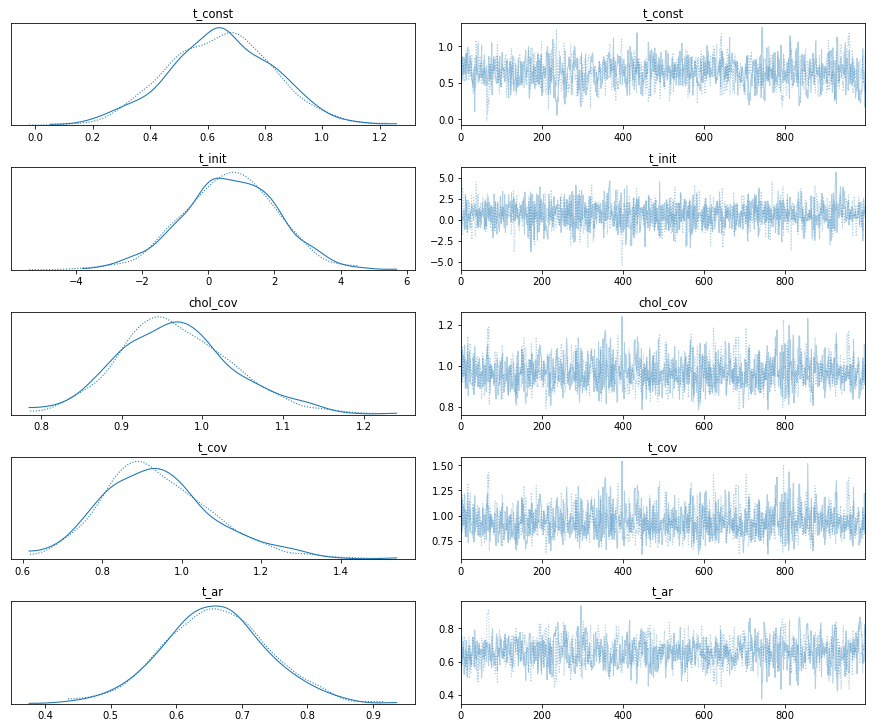

In [26]:
pm.traceplot(trace);

### Check posterior predictive

/opt/conda/envs/rs-model/lib/python3.8/site-packages/arviz/numeric_utils.py:58: UserWarning: kde plot failed, you may want to check your data
  warnings.warn("kde plot failed, you may want to check your data")


IndexError: index 1 is out of bounds for axis 0 with size 1

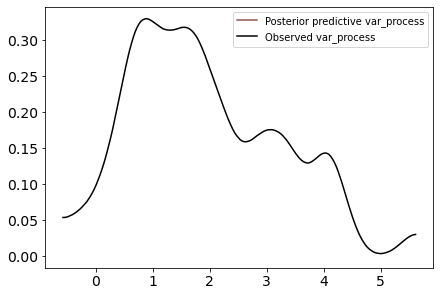

In [27]:
az.plot_ppc(ifd);

### Compare with actual values

In [ ]:
# Estimated covariance matrix
ifd.posterior['t_cov'].mean(dim=['chain', 'draw']).values

In [ ]:
# Actual covariance matrix
vg.coef_covariance.values

In [ ]:
# Estimated constant term
ifd.posterior['t_const'].mean(dim=['chain', 'draw']).values

In [ ]:
vg.coef_const.values

In [ ]:
# Estimated constant term
ifd.posterior['t_ar'].mean(dim=['chain', 'draw']).values

In [ ]:
az.hdi(ifd.posterior['t_ar'].values, hdi_prob=0.95)

In [ ]:
vg.coef_ar.values

In [ ]:
# Estimated initial values
ifd.posterior['t_init'].mean(dim=['chain', 'draw']).values

In [ ]:
# Approximate initial values
init_vals['output'].values

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(
    2, 1, figsize=(20, 12), gridspec_kw={"height_ratios": [3, 1]}
)
raw_data["output"].plot.line(hue="target", ax=ax[0])
ax[1].set_ylabel("exog")
# ax[1].plot(fake_exog, color="black")
plt.show()